The purpose of this notebook is to evaluate GPDs $G_q(x,\eta,t)$ as well as their conformal moments $\mathbb{G}_q(n,\eta,t)$, where, for a generic GPD, we have its conformal moment expansion
\begin{equation}
G_q(x,\eta,t)=\sum_{n=0}^\infty (-1)^{n}p_n(x,\eta)\mathbb{F}_q(n,\eta,t),\qquad G_g(x,\eta,t)=\sum_{n=1}^\infty (-1)^{n-1}\, {^g\!p}_n(x,\eta) \mathbb{G}_g(n,\eta,t),
\end{equation}
where $G=H,E,\widetilde{H},\widetilde{E},H^T,E^T,\widetilde{H}^T,\widetilde{E}^T$.

To this end, we import the MSTW PDF parametrization of PDFs. The conformal moments are obtained by Reggeized $x$ integrals over PDFs at some input scale $\mu_0=1$ GeV and evolved using the pertinent RGEs. THe GPDs are reconstructed using the expansion in conformal partial waves and pertinent Mellin-Barnes integrals to resum their expansion in conformal moments.

In [3]:
# Import necessary libraries and set display options
import numpy as np
# import mpmath as mp
# import matplotlib.pyplot as plt
# from scipy.integrate import quad, trapezoid
# from joblib import Parallel, delayed
# from scipy.special import gamma, digamma

# import time
# import re
# import os

# from mstw_pdf import (
#     plot_uv_minus_dv_pdf, 
#     plot_uv_plus_dv_plus_S_pdf,
#     plot_gluon_pdf
# )

# from aac_pdf import(
#     plot_polarized_uv_minus_dv_pdf,
#     plot_polarized_uv_plus_dv_plus_S_pdf,
#     plot_polarized_gluon_pdf
#     )

from stringy_gpds.core import (
    plot_gpds,plot_gpd_data,
    plot_moments_on_grid,plot_moment,
    evolve_conformal_moment,
    evolve_singlet_D,gluon_helicity,
    quark_helicity, spin_orbit_corelation, total_spin,
    orbital_angular_momentum,
    plot_fourier_transform_singlet_helicity,
    plot_fourier_transform_quark_helicity,
    plot_fourier_transform_quark_spin_orbit_correlation,
    plot_fourier_transform_singlet_spin_orbit_correlation,
    plot_fourier_transform_quark_orbital_angular_momentum,
    plot_fourier_transform_transverse_moments,
    plot_spin_orbit_correlation
)
# Set display options
np.set_printoptions(linewidth=200)

In [ ]:
from stringy_gpds.core import generate_moment_table
import stringy_gpds.config as cfg
import stringy_gpds.core as core
from pathlib import Path
import importlib
from itertools import product

# Make sure INTERPOLATE_INPUT_MOMENTS and INTERPOLATE_MOMENTS is set to False in config
# otherwise there is an error upon import
def generate_all_moment_tables(reload = True):
    def update_param(filename, key, new_value):
        with open(filename, 'r') as file:
            lines = file.readlines()

        with open(filename, 'w') as file:
            for line in lines:
                if line.strip().startswith(f"{key} ="):
                    file.write(f"{key} = {repr(new_value)}\n")
                else:
                    file.write(line)
    mod = False # Keep track of whether INTERPOLATE_INPUT_MOMENTS has already been changed
    cfg_path = Path(cfg.__file__)
    for eta, t, mu in zip(cfg.ETA_ARRAY, cfg.T_ARRAY, cfg.MU_ARRAY):
        for particle,moment_type, moment_label, evolution_order, error_type in product(["quark","gluon"],cfg.MOMENTS, cfg.LABELS, cfg.ORDERS,cfg.ERRORS):
            if particle == "gluon" and moment_type != "singlet":
                continue
            if mu != 1 and not mod:
                print('Reloading modules to interpolate input moments...')
                update_param(cfg_path,'INTERPOLATE_INPUT_MOMENTS',True)
                mod = True
                # Reload to interpolate input moments
                importlib.reload(cfg)
                importlib.reload(core)
                print('Modules reloaded. Proceeding with table generation...')
            if mu == 1 and moment_type == "singlet":
                # Skipping "gluon" for input moments 
                # such that table is not generated twice
                if particle == "gluon":
                    continue
                solution = "+"
                print(f"Working on {moment_type,solution,moment_label, evolution_order, error_type} at (eta,t,mu) = {eta,t,mu}...")
                generate_moment_table(eta,t,mu,solution="+",particle=particle,moment_type=moment_type,moment_label=moment_label,evolution_order=evolution_order,error_type=error_type,step=.1)
                solution = "-"
                print(f"Working on {moment_type,solution,moment_label, evolution_order, error_type} at (eta,t,mu) = {eta,t,mu}...")
                generate_moment_table(eta,t,mu,solution="-",particle=particle,moment_type=moment_type,moment_label=moment_label,evolution_order=evolution_order,error_type=error_type,step=.1)
            if mu == 1 and mod and moment_type == "singlet":
                generate_moment_table(eta,t,mu,solution="+",particle=particle,moment_type=moment_type,moment_label=moment_label,evolution_order=evolution_order,error_type=error_type,step=.1)
            else:
                print(f"Working on {particle,moment_type,moment_label, evolution_order, error_type} at (eta,t,mu) = {eta,t,mu}...")
                generate_moment_table(eta,t,mu,solution=".",particle=particle,moment_type=moment_type,moment_label=moment_label,evolution_order=evolution_order,error_type=error_type,step=.1)
                
    print("Generating quark and gluon singlet moments at input scale")

    for eta, t, mu in zip(cfg.ETA_ARRAY, cfg.T_ARRAY, cfg.MU_ARRAY):
        if mu != 1:
            continue
        for particle, moment_label, evolution_order, error_type in product(["quark","gluon"], cfg.LABELS, cfg.ORDERS,cfg.ERRORS):
            moment_type = "singlet"
            print(f"Working on {particle,moment_type,moment_label, evolution_order, error_type} at (eta,t,mu) = {eta,t,mu}...")
            generate_moment_table(eta,t,mu,solution=".",particle=particle,moment_type=moment_type,moment_label=moment_label,evolution_order=evolution_order,error_type=error_type,step=.1)
    update_param(cfg_path,'INTERPOLATE_MOMENTS',True) # Switch to interpolation of evolved moments
    if reload:
        importlib.reload(cfg)
        importlib.reload(core)
    print("Done")

generate_all_moment_tables()

Working on ('singlet', '+', 'Atilde', 'nlo', 'central') at (eta,t,mu) = (0.33, -0.69, 1)...
Working on ('singlet', '-', 'Atilde', 'nlo', 'central') at (eta,t,mu) = (0.33, -0.69, 1)...
Working on ('singlet', '+', 'Atilde', 'nlo', 'plus') at (eta,t,mu) = (0.33, -0.69, 1)...
Working on ('singlet', '-', 'Atilde', 'nlo', 'plus') at (eta,t,mu) = (0.33, -0.69, 1)...
Working on ('singlet', '+', 'Atilde', 'nlo', 'minus') at (eta,t,mu) = (0.33, -0.69, 1)...
Working on ('singlet', '-', 'Atilde', 'nlo', 'minus') at (eta,t,mu) = (0.33, -0.69, 1)...
Working on ('singlet', '+', 'Atilde', 'nlo', 'central') at (eta,t,mu) = (0, -0.69, 1)...
Working on ('singlet', '-', 'Atilde', 'nlo', 'central') at (eta,t,mu) = (0, -0.69, 1)...
Working on ('singlet', '+', 'Atilde', 'nlo', 'plus') at (eta,t,mu) = (0, -0.69, 1)...
Working on ('singlet', '-', 'Atilde', 'nlo', 'plus') at (eta,t,mu) = (0, -0.69, 1)...
Working on ('singlet', '+', 'Atilde', 'nlo', 'minus') at (eta,t,mu) = (0, -0.69, 1)...
Working on ('singlet'

100%|██████████████████████████████████████████████████████████████████████████████| 4004/4004 [00:17<00:00, 229.39it/s]


Successfully wrote table to /mnt/c/Users/flori/Documents/PostDoc/Data/stringy-gpds/InterpolationTables/singlet_quark_moments_Atilde_nlo_033_069_100.csv
Working on ('quark', 'singlet', 'Atilde', 'nlo', 'plus') at (eta,t,mu) = (0.33, -0.69, 1)...


100%|██████████████████████████████████████████████████████████████████████████████| 4004/4004 [00:19<00:00, 208.70it/s]


Successfully wrote table to /mnt/c/Users/flori/Documents/PostDoc/Data/stringy-gpds/InterpolationTables/singlet_quark_moments_Atilde_nlo_033_069_100_plus.csv
Working on ('quark', 'singlet', 'Atilde', 'nlo', 'minus') at (eta,t,mu) = (0.33, -0.69, 1)...


100%|██████████████████████████████████████████████████████████████████████████████| 4004/4004 [00:22<00:00, 176.76it/s]


Successfully wrote table to /mnt/c/Users/flori/Documents/PostDoc/Data/stringy-gpds/InterpolationTables/singlet_quark_moments_Atilde_nlo_033_069_100_minus.csv
Working on ('gluon', 'singlet', 'Atilde', 'nlo', 'central') at (eta,t,mu) = (0.33, -0.69, 1)...


100%|██████████████████████████████████████████████████████████████████████████████| 4004/4004 [00:20<00:00, 192.36it/s]


Successfully wrote table to /mnt/c/Users/flori/Documents/PostDoc/Data/stringy-gpds/InterpolationTables/singlet_gluon_moments_Atilde_nlo_033_069_100.csv
Working on ('gluon', 'singlet', 'Atilde', 'nlo', 'plus') at (eta,t,mu) = (0.33, -0.69, 1)...


100%|██████████████████████████████████████████████████████████████████████████████| 4004/4004 [00:29<00:00, 134.43it/s]


Successfully wrote table to /mnt/c/Users/flori/Documents/PostDoc/Data/stringy-gpds/InterpolationTables/singlet_gluon_moments_Atilde_nlo_033_069_100_plus.csv
Working on ('gluon', 'singlet', 'Atilde', 'nlo', 'minus') at (eta,t,mu) = (0.33, -0.69, 1)...


100%|███████████████████████████████████████████████████████████████████████████████| 4004/4004 [00:40<00:00, 99.58it/s]


Successfully wrote table to /mnt/c/Users/flori/Documents/PostDoc/Data/stringy-gpds/InterpolationTables/singlet_gluon_moments_Atilde_nlo_033_069_100_minus.csv
Working on ('quark', 'singlet', 'Atilde', 'nlo', 'central') at (eta,t,mu) = (0, -0.69, 1)...


100%|███████████████████████████████████████████████████████████████████████████████| 4004/4004 [00:50<00:00, 79.64it/s]


Successfully wrote table to /mnt/c/Users/flori/Documents/PostDoc/Data/stringy-gpds/InterpolationTables/singlet_quark_moments_Atilde_nlo_000_069_100.csv
Working on ('quark', 'singlet', 'Atilde', 'nlo', 'plus') at (eta,t,mu) = (0, -0.69, 1)...


100%|███████████████████████████████████████████████████████████████████████████████| 4004/4004 [00:48<00:00, 83.17it/s]


Successfully wrote table to /mnt/c/Users/flori/Documents/PostDoc/Data/stringy-gpds/InterpolationTables/singlet_quark_moments_Atilde_nlo_000_069_100_plus.csv
Working on ('quark', 'singlet', 'Atilde', 'nlo', 'minus') at (eta,t,mu) = (0, -0.69, 1)...


100%|██████████████████████████████████████████████████████████████████████████████| 4004/4004 [00:33<00:00, 118.65it/s]


Successfully wrote table to /mnt/c/Users/flori/Documents/PostDoc/Data/stringy-gpds/InterpolationTables/singlet_quark_moments_Atilde_nlo_000_069_100_minus.csv
Working on ('gluon', 'singlet', 'Atilde', 'nlo', 'central') at (eta,t,mu) = (0, -0.69, 1)...


100%|██████████████████████████████████████████████████████████████████████████████| 4004/4004 [00:24<00:00, 161.10it/s]


Successfully wrote table to /mnt/c/Users/flori/Documents/PostDoc/Data/stringy-gpds/InterpolationTables/singlet_gluon_moments_Atilde_nlo_000_069_100.csv
Working on ('gluon', 'singlet', 'Atilde', 'nlo', 'plus') at (eta,t,mu) = (0, -0.69, 1)...


100%|██████████████████████████████████████████████████████████████████████████████| 4004/4004 [00:29<00:00, 136.38it/s]


Successfully wrote table to /mnt/c/Users/flori/Documents/PostDoc/Data/stringy-gpds/InterpolationTables/singlet_gluon_moments_Atilde_nlo_000_069_100_plus.csv
Working on ('gluon', 'singlet', 'Atilde', 'nlo', 'minus') at (eta,t,mu) = (0, -0.69, 1)...


100%|██████████████████████████████████████████████████████████████████████████████| 4004/4004 [00:39<00:00, 100.40it/s]


Successfully wrote table to /mnt/c/Users/flori/Documents/PostDoc/Data/stringy-gpds/InterpolationTables/singlet_gluon_moments_Atilde_nlo_000_069_100_minus.csv
Working on ('quark', 'singlet', 'Atilde', 'nlo', 'central') at (eta,t,mu) = (0.1, -0.23, 1)...


100%|███████████████████████████████████████████████████████████████████████████████| 4004/4004 [00:44<00:00, 89.26it/s]


Successfully wrote table to /mnt/c/Users/flori/Documents/PostDoc/Data/stringy-gpds/InterpolationTables/singlet_quark_moments_Atilde_nlo_010_023_100.csv
Working on ('quark', 'singlet', 'Atilde', 'nlo', 'plus') at (eta,t,mu) = (0.1, -0.23, 1)...


100%|██████████████████████████████████████████████████████████████████████████████| 4004/4004 [00:33<00:00, 120.14it/s]


Successfully wrote table to /mnt/c/Users/flori/Documents/PostDoc/Data/stringy-gpds/InterpolationTables/singlet_quark_moments_Atilde_nlo_010_023_100_plus.csv
Working on ('quark', 'singlet', 'Atilde', 'nlo', 'minus') at (eta,t,mu) = (0.1, -0.23, 1)...


100%|██████████████████████████████████████████████████████████████████████████████| 4004/4004 [00:28<00:00, 139.97it/s]


Successfully wrote table to /mnt/c/Users/flori/Documents/PostDoc/Data/stringy-gpds/InterpolationTables/singlet_quark_moments_Atilde_nlo_010_023_100_minus.csv
Working on ('gluon', 'singlet', 'Atilde', 'nlo', 'central') at (eta,t,mu) = (0.1, -0.23, 1)...


100%|██████████████████████████████████████████████████████████████████████████████| 4004/4004 [00:30<00:00, 133.30it/s]


Successfully wrote table to /mnt/c/Users/flori/Documents/PostDoc/Data/stringy-gpds/InterpolationTables/singlet_gluon_moments_Atilde_nlo_010_023_100.csv
Working on ('gluon', 'singlet', 'Atilde', 'nlo', 'plus') at (eta,t,mu) = (0.1, -0.23, 1)...


100%|███████████████████████████████████████████████████████████████████████████████| 4004/4004 [00:53<00:00, 74.81it/s]


Successfully wrote table to /mnt/c/Users/flori/Documents/PostDoc/Data/stringy-gpds/InterpolationTables/singlet_gluon_moments_Atilde_nlo_010_023_100_plus.csv
Working on ('gluon', 'singlet', 'Atilde', 'nlo', 'minus') at (eta,t,mu) = (0.1, -0.23, 1)...


100%|███████████████████████████████████████████████████████████████████████████████| 4004/4004 [00:44<00:00, 89.09it/s]


Successfully wrote table to /mnt/c/Users/flori/Documents/PostDoc/Data/stringy-gpds/InterpolationTables/singlet_gluon_moments_Atilde_nlo_010_023_100_minus.csv


In [2]:
from stringy_gpds.fit import dipole_fit_moment
from itertools import product
plot_fit = False
for error_type, evolution_order in  product(["central","plus","minus"],["lo","nlo"]):
    dipole_fit_moment(1,0,2,particle="quark",moment_type="non_singlet_isovector",moment_label="B",evolution_order=evolution_order,error_type=error_type,plot_fit=plot_fit)
    dipole_fit_moment(1,0,2,particle="quark",moment_type="non_singlet_isoscalar",moment_label="B",evolution_order=evolution_order,error_type=error_type,plot_fit=plot_fit)
    dipole_fit_moment(2,0,2,particle="quark",moment_type="non_singlet_isovector",moment_label="B",evolution_order=evolution_order,error_type=error_type,plot_fit=plot_fit)
    dipole_fit_moment(2,0,2,particle="quark",moment_type="non_singlet_isoscalar",moment_label="B",evolution_order=evolution_order,error_type=error_type,plot_fit=plot_fit)
    dipole_fit_moment(3,0,2,particle="quark",moment_type="non_singlet_isovector",moment_label="B",evolution_order=evolution_order,error_type=error_type,plot_fit=plot_fit)
    dipole_fit_moment(3,0,2,particle="quark",moment_type="non_singlet_isoscalar",moment_label="B",evolution_order=evolution_order,error_type=error_type,plot_fit=plot_fit)
    dipole_fit_moment(4,0,2,particle="quark",moment_type="non_singlet_isovector",moment_label="B",evolution_order=evolution_order,error_type=error_type,plot_fit=plot_fit)
    dipole_fit_moment(4,0,2,particle="quark",moment_type="non_singlet_isoscalar",moment_label="B",evolution_order=evolution_order,error_type=error_type,plot_fit=plot_fit)
    dipole_fit_moment(1,0,2,particle="quark",moment_type="non_singlet_isovector",moment_label="A",evolution_order=evolution_order,error_type=error_type,plot_fit=plot_fit)
    dipole_fit_moment(1,0,2,particle="quark",moment_type="non_singlet_isoscalar",moment_label="A",evolution_order=evolution_order,error_type=error_type,plot_fit=plot_fit)
    dipole_fit_moment(2,0,2,particle="quark",moment_type="non_singlet_isovector",moment_label="A",evolution_order=evolution_order,error_type=error_type,plot_fit=plot_fit)
    dipole_fit_moment(2,0,2,particle="quark",moment_type="non_singlet_isoscalar",moment_label="A",evolution_order=evolution_order,error_type=error_type,plot_fit=plot_fit)
    dipole_fit_moment(3,0,2,particle="quark",moment_type="non_singlet_isovector",moment_label="A",evolution_order=evolution_order,error_type=error_type,plot_fit=plot_fit)
    dipole_fit_moment(3,0,2,particle="quark",moment_type="non_singlet_isoscalar",moment_label="A",evolution_order=evolution_order,error_type=error_type,plot_fit=plot_fit)
    dipole_fit_moment(4,0,2,particle="quark",moment_type="non_singlet_isovector",moment_label="A",evolution_order=evolution_order,error_type=error_type,plot_fit=plot_fit)
    dipole_fit_moment(4,0,2,particle="quark",moment_type="non_singlet_isoscalar",moment_label="A",evolution_order=evolution_order,error_type=error_type,plot_fit=plot_fit)


    dipole_fit_moment(1,0,2,particle="quark",moment_type="non_singlet_isovector",moment_label="Atilde",evolution_order=evolution_order,error_type=error_type,plot_fit=plot_fit)
    dipole_fit_moment(1,0,2,particle="quark",moment_type="non_singlet_isoscalar",moment_label="Atilde",evolution_order=evolution_order,error_type=error_type,plot_fit=plot_fit)
    dipole_fit_moment(2,0,2,particle="quark",moment_type="non_singlet_isovector",moment_label="Atilde",evolution_order=evolution_order,error_type=error_type,plot_fit=plot_fit)
    dipole_fit_moment(2,0,2,particle="quark",moment_type="non_singlet_isoscalar",moment_label="Atilde",evolution_order=evolution_order,error_type=error_type,plot_fit=plot_fit)
    dipole_fit_moment(1,0,2,particle="quark",moment_type="singlet",moment_label="Atilde",evolution_order=evolution_order,error_type=error_type,plot_fit=plot_fit)
    dipole_fit_moment(1,0,2,particle="gluon",moment_type="singlet",moment_label="Atilde",evolution_order=evolution_order,error_type=error_type,plot_fit=plot_fit)

(n, eta, mu, particle, moment_type, moment_label, evolution_order,error_type) = (1, 0, 2, 'quark', 'singlet', 'Atilde', 'lo', 'minus').
Positive values:15, Negative values: 1


Time for initial sampling for parameters (eta,t,mu) = ((0, -0.69, 2)): 18.338287 seconds


100%|███████████████████████████████████████████████████████████████████████████████████| 51/51 [00:10<00:00,  4.66it/s]


Time for plot computation for parameters (eta,t,mu) = ((0, -0.69, 2)): 32.264858 seconds
Saved data to /mnt/c/Users/flori/Documents/PostDoc/Data/stringy-gpds/GPDs/non_singlet_isovector_quark_GPD_Htilde_nlo_000_069_200.csv
Saved data to /mnt/c/Users/flori/Documents/PostDoc/Data/stringy-gpds/GPDs/non_singlet_isovector_quark_GPD_Htilde_nlo_000_069_200_plus.csv
Saved data to /mnt/c/Users/flori/Documents/PostDoc/Data/stringy-gpds/GPDs/non_singlet_isovector_quark_GPD_Htilde_nlo_000_069_200_minus.csv
Time for initial sampling for parameters (eta,t,mu) = ((0, -0.39, 3)): 2.888792 seconds


100%|███████████████████████████████████████████████████████████████████████████████████| 51/51 [00:10<00:00,  4.71it/s]


Time for plot computation for parameters (eta,t,mu) = ((0, -0.39, 3)): 31.994542 seconds
Saved data to /mnt/c/Users/flori/Documents/PostDoc/Data/stringy-gpds/GPDs/non_singlet_isovector_quark_GPD_Htilde_nlo_000_039_300.csv
Saved data to /mnt/c/Users/flori/Documents/PostDoc/Data/stringy-gpds/GPDs/non_singlet_isovector_quark_GPD_Htilde_nlo_000_039_300_plus.csv
Saved data to /mnt/c/Users/flori/Documents/PostDoc/Data/stringy-gpds/GPDs/non_singlet_isovector_quark_GPD_Htilde_nlo_000_039_300_minus.csv
Time for initial sampling for parameters (eta,t,mu) = ((0.33, -0.69, 2)): 5.708486 seconds


100%|███████████████████████████████████████████████████████████████████████████████████| 52/52 [00:12<00:00,  4.26it/s]


Time for plot computation for parameters (eta,t,mu) = ((0.33, -0.69, 2)): 43.177785 seconds
Saved data to /mnt/c/Users/flori/Documents/PostDoc/Data/stringy-gpds/GPDs/non_singlet_isovector_quark_GPD_Htilde_nlo_033_069_200.csv
Saved data to /mnt/c/Users/flori/Documents/PostDoc/Data/stringy-gpds/GPDs/non_singlet_isovector_quark_GPD_Htilde_nlo_033_069_200_plus.csv
Saved data to /mnt/c/Users/flori/Documents/PostDoc/Data/stringy-gpds/GPDs/non_singlet_isovector_quark_GPD_Htilde_nlo_033_069_200_minus.csv
File saved to /mnt/c/Users/flori/Documents/PostDoc/Plots/stringy-gpds/non_singlet_isovector_quark_GPD_Htilde.pdf


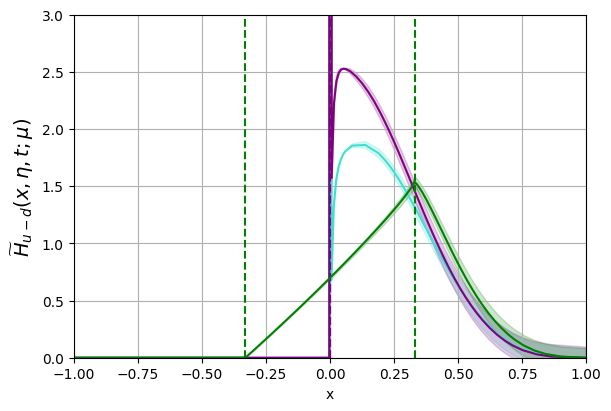

In [1]:
from stringy_gpds.core import plot_gpds
eta_array = [0,0,0.33]
t_array = [-0.69,-0.39,-0.69]
mu_array = [2,3,2]
colors = ["turquoise","purple","green"]
plot_gpds(eta_array,t_array,mu_array,colors,particle="quark",gpd_type="non_singlet_isovector",gpd_label="Htilde",evolution_order="nlo",error_bars=True, read_from_file= False,write_to_file=True, y_0=0, y_1=3)

/home/hechenvanmountain/.local/lib/python3.10/site-packages/scipy/interpolate/_interpolate.py:479: RuntimeWarning: divide by zero encountered in divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]


Time for plot computation for parameters (eta,t) = ((0.0, -0.69)): 0.037012 seconds
Time for plot computation for parameters (eta,t) = ((0.33, -0.69)): 0.042616 seconds
Time for plot computation for parameters (eta,t) = ((0.0, -0.39)): 0.035804 seconds


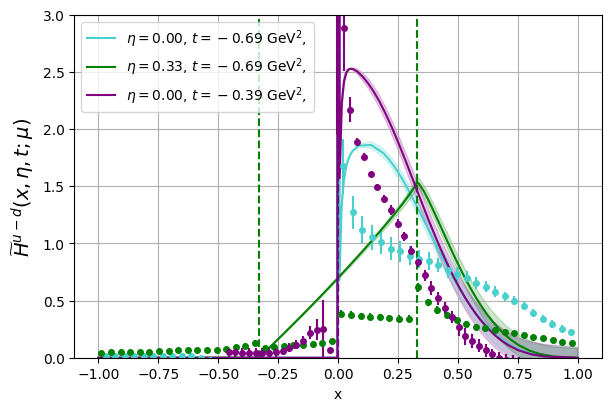

In [15]:
from stringy_gpds.core import plot_gpd_data
plot_gpd_data(particle="quark",gpd_type="non_singlet_isovector",gpd_label="Htilde",y_0=0,y_1=3)

Time for initial sampling for parameters (eta,t,mu) = ((0, -0.69, 2)): 2.938707 seconds


100%|█████████████████████████████████████████████████████████████████████████████████| 101/101 [00:25<00:00,  3.90it/s]


Time for plot computation for parameters (eta,t,mu) = ((0, -0.69, 2)): 60.098244 seconds
Saved data to /mnt/c/Users/flori/Documents/PostDoc/Data/stringy-gpds/GPDs/non_singlet_isovector_quark_GPD_E_nlo_000_069_200.csv
Saved data to /mnt/c/Users/flori/Documents/PostDoc/Data/stringy-gpds/GPDs/non_singlet_isovector_quark_GPD_E_nlo_000_069_200_plus.csv
Saved data to /mnt/c/Users/flori/Documents/PostDoc/Data/stringy-gpds/GPDs/non_singlet_isovector_quark_GPD_E_nlo_000_069_200_minus.csv
Time for initial sampling for parameters (eta,t,mu) = ((0.33, -0.69, 2)): 6.526348 seconds


100%|█████████████████████████████████████████████████████████████████████████████████| 102/102 [00:17<00:00,  6.00it/s]


Time for plot computation for parameters (eta,t,mu) = ((0.33, -0.69, 2)): 63.129195 seconds
Saved data to /mnt/c/Users/flori/Documents/PostDoc/Data/stringy-gpds/GPDs/non_singlet_isovector_quark_GPD_E_nlo_033_069_200.csv
Saved data to /mnt/c/Users/flori/Documents/PostDoc/Data/stringy-gpds/GPDs/non_singlet_isovector_quark_GPD_E_nlo_033_069_200_plus.csv
Saved data to /mnt/c/Users/flori/Documents/PostDoc/Data/stringy-gpds/GPDs/non_singlet_isovector_quark_GPD_E_nlo_033_069_200_minus.csv
Time for initial sampling for parameters (eta,t,mu) = ((0.1, -0.23, 2)): 2.885416 seconds


100%|█████████████████████████████████████████████████████████████████████████████████| 102/102 [00:29<00:00,  3.49it/s]


Time for plot computation for parameters (eta,t,mu) = ((0.1, -0.23, 2)): 67.194494 seconds
Saved data to /mnt/c/Users/flori/Documents/PostDoc/Data/stringy-gpds/GPDs/non_singlet_isovector_quark_GPD_E_nlo_010_023_200.csv
Saved data to /mnt/c/Users/flori/Documents/PostDoc/Data/stringy-gpds/GPDs/non_singlet_isovector_quark_GPD_E_nlo_010_023_200_plus.csv
Saved data to /mnt/c/Users/flori/Documents/PostDoc/Data/stringy-gpds/GPDs/non_singlet_isovector_quark_GPD_E_nlo_010_023_200_minus.csv
File saved to /mnt/c/Users/flori/Documents/PostDoc/Plots/stringy-gpds/non_singlet_isovector_quark_GPD_E.pdf


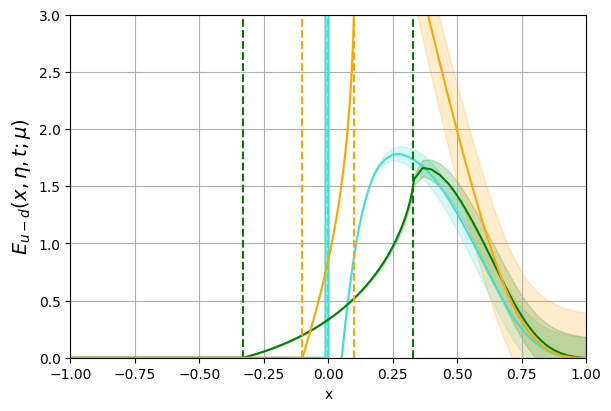

In [2]:
from stringy_gpds.core import plot_gpds
eta_array = [0,0.33,0.1]
t_array = [-0.69,-0.69,-0.23]
mu_array = [2,2,2]
colors = ["turquoise","green","orange"]
plot_gpds(eta_array,t_array,mu_array,colors,particle="quark",gpd_type="non_singlet_isovector",gpd_label="E",evolution_order="nlo",error_bars=True, read_from_file= False,write_to_file=True, y_0=0, y_1=3,n_points=100)

/home/hechenvanmountain/.local/lib/python3.10/site-packages/scipy/interpolate/_interpolate.py:479: RuntimeWarning: divide by zero encountered in divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]


Time for plot computation for parameters (eta,t) = ((0.0, -0.69)): 0.038610 seconds
Time for plot computation for parameters (eta,t) = ((0.33, -0.69)): 0.020789 seconds
Time for plot computation for parameters (eta,t) = ((0.1, -0.23)): 0.019697 seconds


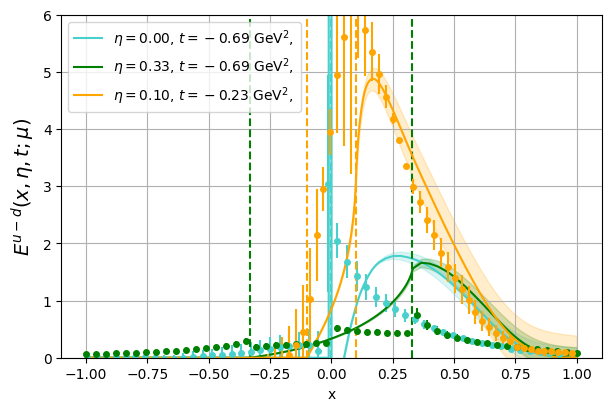

In [18]:
from stringy_gpds.core import plot_gpd_data
plot_gpd_data(particle="quark",gpd_type="non_singlet_isovector",gpd_label="E",y_0=0,y_1=6)

In [ ]:
j_u_minus_d, j_u_minus_d_plus, j_u_minus_d_minus =  total_spin(0,2,particle="quark",moment_type="non_singlet_isovector",evolution_order="nlo")
j_u_plus_d, j_u_plus_d_plus, j_u_plus_d_minus =  total_spin(0,2,particle="quark",moment_type="non_singlet_isoscalar",evolution_order="nlo")
j_u = (j_u_minus_d + j_u_plus_d)/2
j_d = (j_u_plus_d - j_u_minus_d)/2
j_u_plus = np.sqrt(j_u_minus_d_plus**2+j_u_plus_d_plus**2)/2
j_u_minus = np.sqrt(j_u_minus_d_minus**2+j_u_plus_d_minus**2)/2
# print(l_u_minus_d_plus,l_u_minus_d_minus)
# print(l_u_plus_d_plus,l_u_plus_d_minus)
print(j_u_plus_d,j_u_plus_d_plus,j_u_plus_d_minus)
print(j_u_minus_d,j_u_minus_d_plus,j_u_minus_d_minus)
print(j_u,j_d)
print(j_u_plus,j_u_minus)
# print(l_u+l_d+l_s)

0.21835052653741485 0.028299653892407985 0.030462764405107513
0.5214564353978949 0.11422174071386074 0.12295238629194265
0.36990348096765485 -0.15155295443024003
0.05883765049297625 0.0633349613366981


Time for plot computation for parameters (eta,t,mu) = ((0.001, -0.001, 2)): 0.011715 seconds
Time for plot computation for parameters (eta,t,mu) = ((0.1, -0.23, 2)): 0.012970 seconds
Time for plot computation for parameters (eta,t,mu) = ((0.3333333333333333, -0.69, 2)): 0.009802 seconds
File saved to /mnt/c/Users/flori/Documents/PostDoc/Plots/stringy-gpds/singlet_quark_GPD_Htilde.pdf


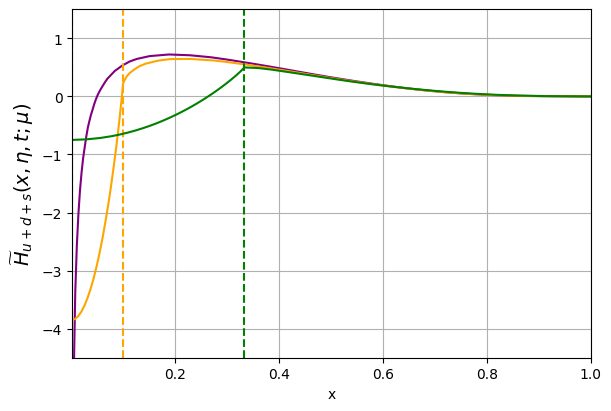

In [ ]:
eta_array = [1e-3,0.1,1/3]
t_array = [-1e-3,-0.23,-0.69]
mu_array = [2,2,2]
colors = ["purple","orange","green"]
plot_gpds(eta_array,t_array,mu_array,colors,particle="quark",gpd_type="singlet",gpd_label="Htilde",error_bars=False, read_from_file= True,write_to_file=False, y_0= -4.5, y_1 =1.5)

Plots of conformal moments $\mathbb{G}(n,\eta,tb_\perp)$ in momentum space

In [ ]:
from stringy_gpds.core import plot_fourier_transform_singlet_spin_orbit_correlation
# plot_fourier_transform_singlet_spin_orbit_correlation(0,2,particle="gluon",read_from_file=False,write_to_file=True,evolution_order="nlo",b_max=4, n_b = 50,Delta_max=8,vmin = -.6, vmax = 0.05 ,ymin=-1.8, ymax = .8)
# plot_fourier_transform_singlet_spin_orbit_correlation(0,2,particle="quark",read_from_file=False,write_to_file=True,evolution_order="nlo",b_max=4, n_b = 50,Delta_max=8,vmin = -.6, vmax = 0.05 ,ymin=-1.8, ymax = .8)

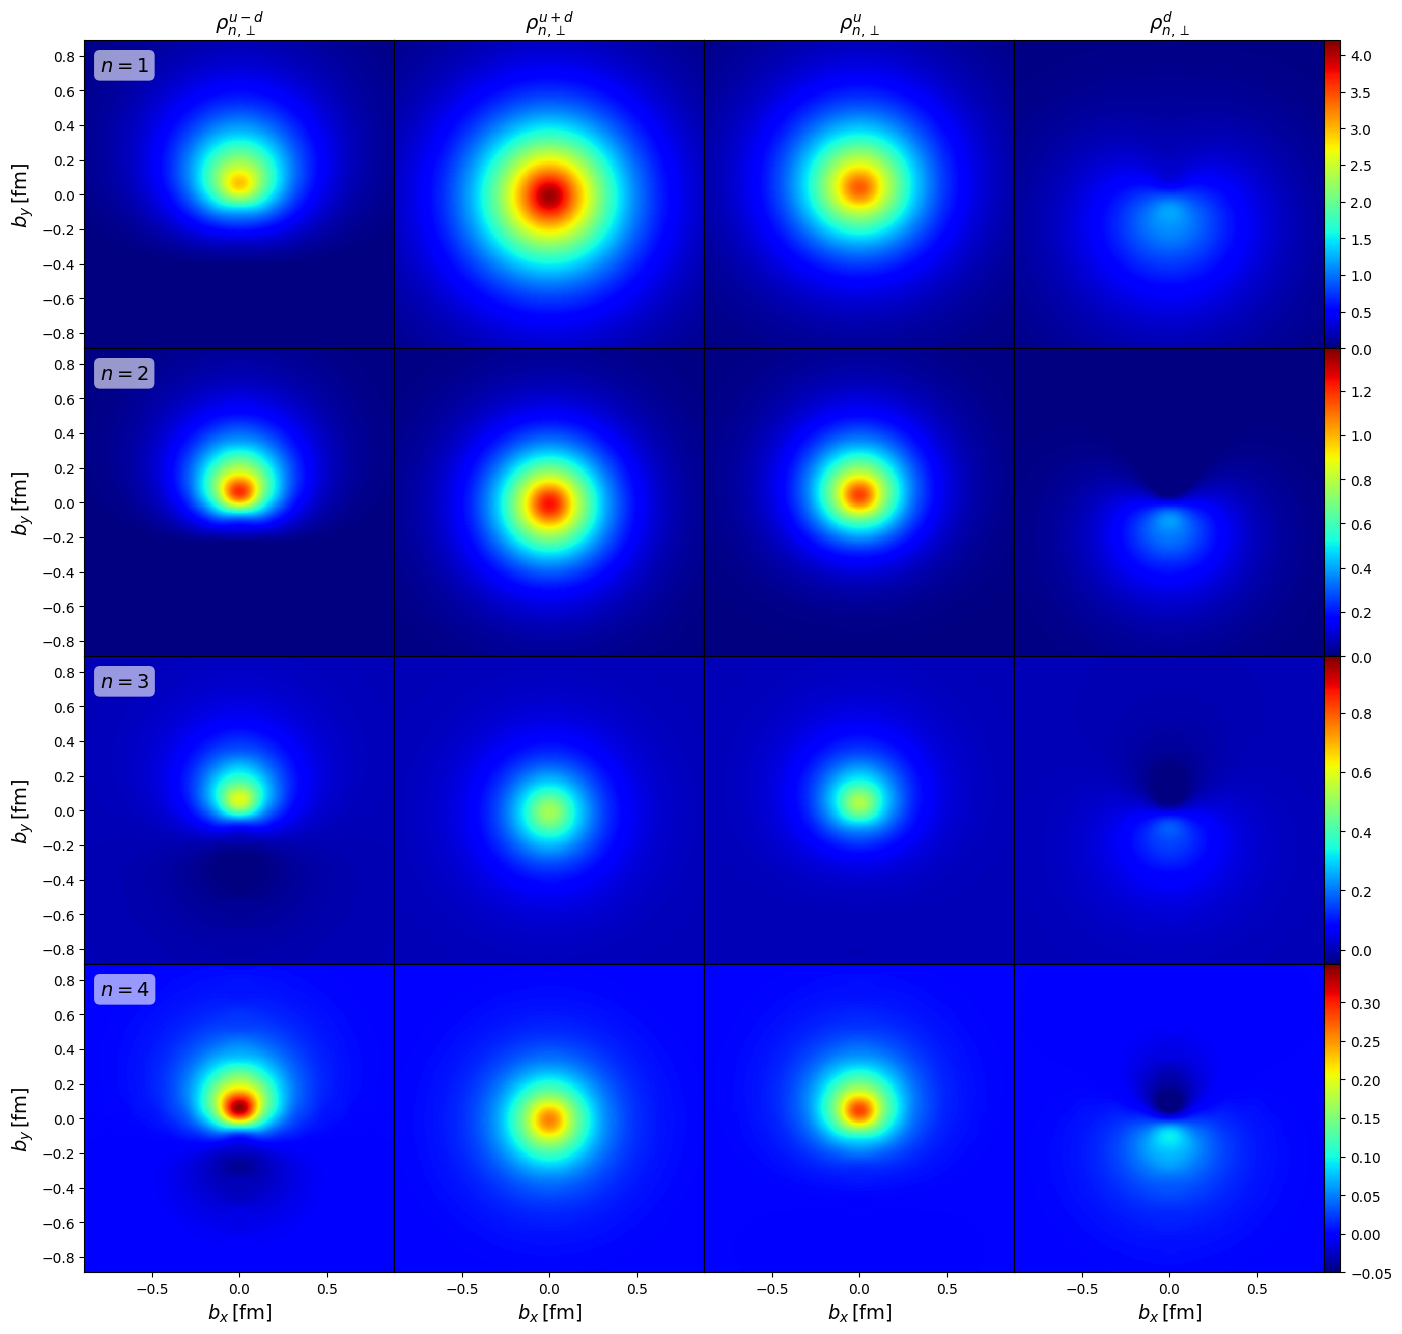

In [1]:
from stringy_gpds.plot import plot_fourier_transform_transverse_moments_grid
plot_fourier_transform_transverse_moments_grid(4,0,2,vmin=[0,0,-0.05,-0.05],vmax=[4.2,1.39,.99,.349])

Saved data to /mnt/c/Users/flori/Documents/PostDoc/Data/stringy-gpds/ImpactParameterMoments/imp_param_transv_pol_moment_j_1_non_singlet_isovector_000_000_200.csv
Saved data to /mnt/c/Users/flori/Documents/PostDoc/Data/stringy-gpds/ImpactParameterMoments/imp_param_transv_pol_moment_j_1_non_singlet_isoscalar_000_000_200.csv
Saved data to /mnt/c/Users/flori/Documents/PostDoc/Data/stringy-gpds/ImpactParameterMoments/imp_param_transv_pol_moment_j_1_u_000_000_200.csv
Saved data to /mnt/c/Users/flori/Documents/PostDoc/Data/stringy-gpds/ImpactParameterMoments/imp_param_transv_pol_moment_j_1_d_000_000_200.csv


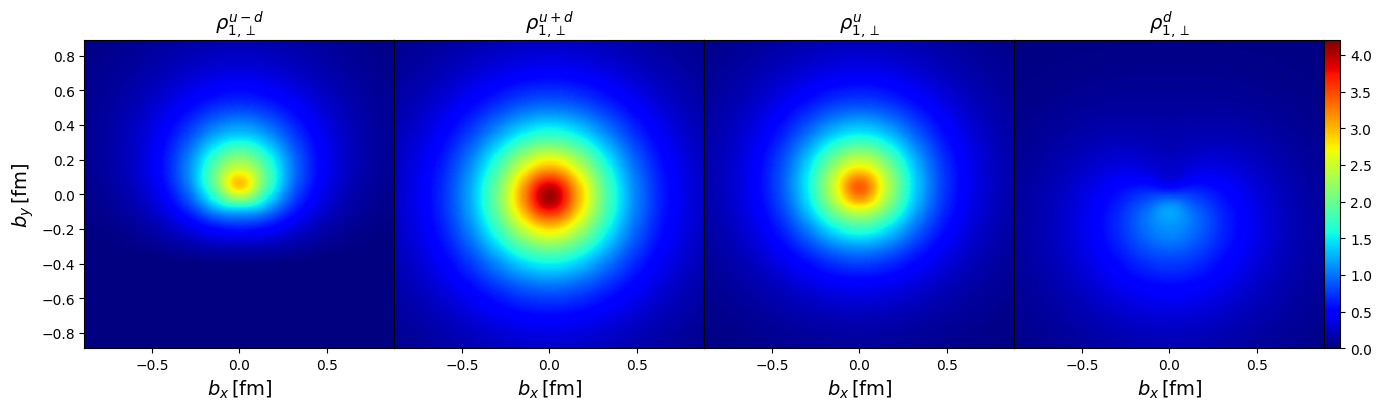

Saved data to /mnt/c/Users/flori/Documents/PostDoc/Data/stringy-gpds/ImpactParameterMoments/imp_param_transv_pol_moment_j_2_non_singlet_isovector_000_000_200.csv
Saved data to /mnt/c/Users/flori/Documents/PostDoc/Data/stringy-gpds/ImpactParameterMoments/imp_param_transv_pol_moment_j_2_non_singlet_isoscalar_000_000_200.csv
Saved data to /mnt/c/Users/flori/Documents/PostDoc/Data/stringy-gpds/ImpactParameterMoments/imp_param_transv_pol_moment_j_2_u_000_000_200.csv
Saved data to /mnt/c/Users/flori/Documents/PostDoc/Data/stringy-gpds/ImpactParameterMoments/imp_param_transv_pol_moment_j_2_d_000_000_200.csv


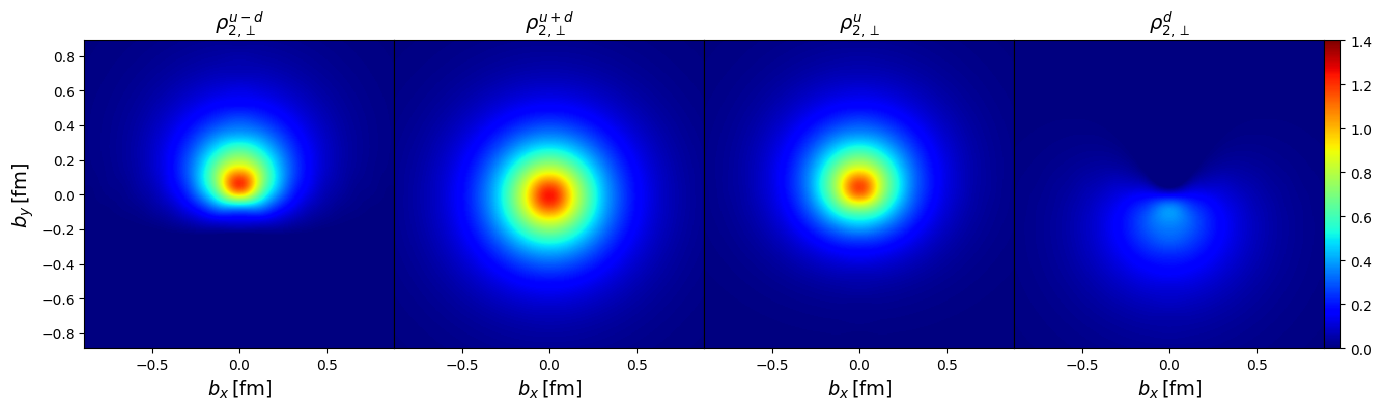

Saved data to /mnt/c/Users/flori/Documents/PostDoc/Data/stringy-gpds/ImpactParameterMoments/imp_param_transv_pol_moment_j_3_non_singlet_isovector_000_000_200.csv
Saved data to /mnt/c/Users/flori/Documents/PostDoc/Data/stringy-gpds/ImpactParameterMoments/imp_param_transv_pol_moment_j_3_non_singlet_isoscalar_000_000_200.csv
Saved data to /mnt/c/Users/flori/Documents/PostDoc/Data/stringy-gpds/ImpactParameterMoments/imp_param_transv_pol_moment_j_3_u_000_000_200.csv
Saved data to /mnt/c/Users/flori/Documents/PostDoc/Data/stringy-gpds/ImpactParameterMoments/imp_param_transv_pol_moment_j_3_d_000_000_200.csv


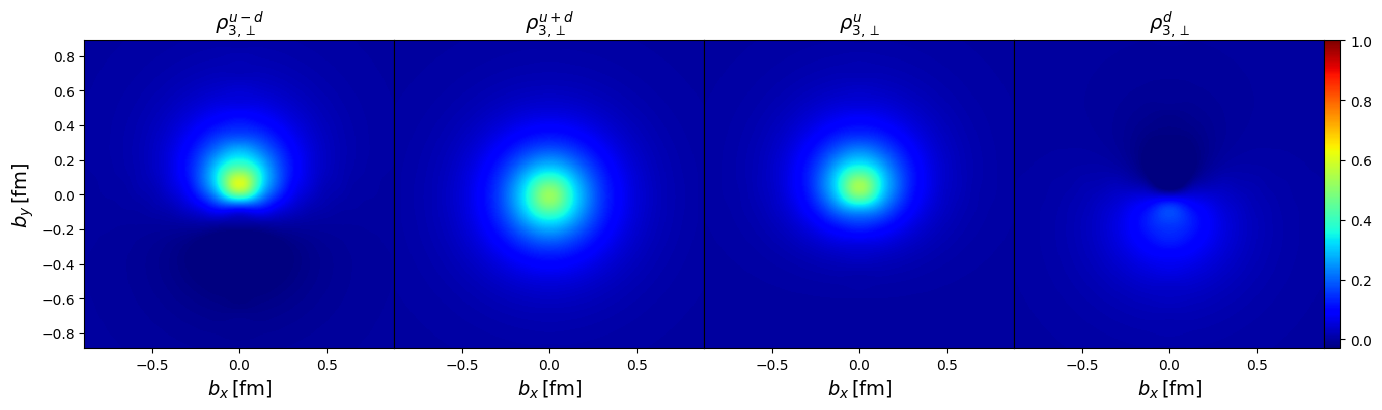

Saved data to /mnt/c/Users/flori/Documents/PostDoc/Data/stringy-gpds/ImpactParameterMoments/imp_param_transv_pol_moment_j_4_non_singlet_isovector_000_000_200.csv
Saved data to /mnt/c/Users/flori/Documents/PostDoc/Data/stringy-gpds/ImpactParameterMoments/imp_param_transv_pol_moment_j_4_non_singlet_isoscalar_000_000_200.csv
Saved data to /mnt/c/Users/flori/Documents/PostDoc/Data/stringy-gpds/ImpactParameterMoments/imp_param_transv_pol_moment_j_4_u_000_000_200.csv
Saved data to /mnt/c/Users/flori/Documents/PostDoc/Data/stringy-gpds/ImpactParameterMoments/imp_param_transv_pol_moment_j_4_d_000_000_200.csv


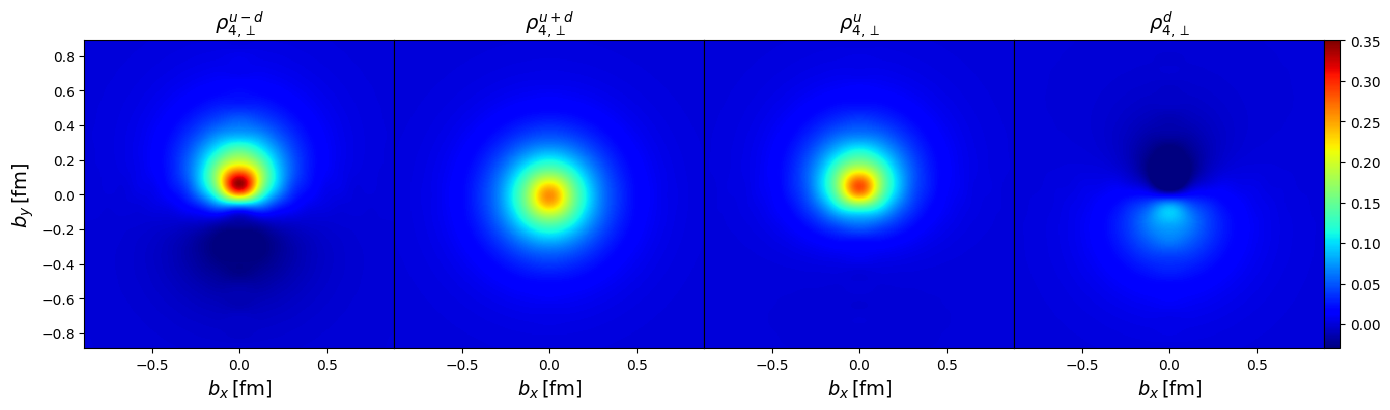

In [19]:
from stringy_gpds.core import plot_fourier_transform_transverse_moments
plot_fourier_transform_transverse_moments(1,0,2,moment_type="all",read_from_file=False,write_to_file=True,interpolation=True,vmin=0, vmax=4.2,evolution_order="nlo")
plot_fourier_transform_transverse_moments(2,0,2,moment_type="all",read_from_file=False,write_to_file=True,interpolation=True,vmin=0, vmax=1.4,evolution_order="nlo")
plot_fourier_transform_transverse_moments(3,0,2,moment_type="all",read_from_file=False,write_to_file=True,interpolation=True,vmin=-.03, vmax=1,evolution_order="nlo")
plot_fourier_transform_transverse_moments(4,0,2,moment_type="all",read_from_file=False,write_to_file=True,interpolation=True,vmin=-.03, vmax=.35,evolution_order="nlo")

In [6]:
l_u_minus_d, l_u_minus_d_plus ,l_u_minus_d_minus = orbital_angular_momentum(0,2)
l_u_plus_d, l_u_plus_d_plus ,l_u_plus_d_minus = orbital_angular_momentum(0,2,moment_type="non_singlet_isoscalar")
l_s, _ ,_ = orbital_angular_momentum(0,2,moment_type="singlet")
l_u = (l_u_minus_d + l_u_plus_d)/2
l_d = (l_u_plus_d - l_u_minus_d)/2
l_u_plus = np.sqrt(l_u_minus_d_plus**2+l_u_plus_d_plus**2)/2
l_u_minus = np.sqrt(l_u_minus_d_minus**2+l_u_plus_d_minus**2)/2
# print(l_u_minus_d_plus,l_u_minus_d_minus)
# print(l_u_plus_d_plus,l_u_plus_d_minus)
print(l_u_plus_d,l_u_plus_d_plus,l_u_plus_d_minus)
print(l_u_minus_d,l_u_minus_d_plus,l_u_minus_d_minus)
print(l_u,l_d,l_s)
print(l_u_plus,l_u_minus)
# print(l_u+l_d+l_s)

-0.03515109816975892 0.06029649825648719 0.05994383876564187
-0.219103215838246 0.1182642498189208 0.11545418706579208
-0.12712715700400246 0.09197605883424353 0.0152597925474197
0.06637412991374476 0.06504408719665489


In [4]:
s_u_minus_d, s_u_minus_d_plus, s_u_minus_d_minus = quark_helicity(0,2,moment_type="non_singlet_isovector")
s_u_plus_d, s_u_plus_d_plus, s_u_plus_d_minus = quark_helicity(0,2,moment_type="non_singlet_isoscalar")
s_s, s_s_plus, s_s_minus= quark_helicity(0,2,moment_type="singlet")
s_g, s_g_plus, s_g_minus = gluon_helicity(0,2)
s_u = (s_u_plus_d+s_u_minus_d)/2
s_u_plus = np.sqrt(s_u_minus_d_plus**2+s_u_plus_d_plus**2)/2
s_u_minus = np.sqrt(s_u_minus_d_minus**2+s_u_plus_d_minus**2)/2
s_d = (s_u_plus_d-s_u_minus_d)/2
print(s_u_minus_d,s_u_minus_d_minus,s_u_minus_d_plus)
print(s_u_plus_d,s_u_plus_d_plus,s_u_plus_d_minus)
print(s_u,s_u_plus,s_u_minus)
print(s_d,s_u_plus,s_u_minus)
# print(s_s,s_s_plus,s_s_minus)
# print(s_g,s_g_plus,s_g_minus)
# print(s_u+s_d+s_s)
# print(s_g)

0.6399707831823318 0.08115649217992948 0.08115649217992948
0.2060500053406073 0.05619504848825929 0.05619504848825929
0.4230103942614696 0.049356508429863555 0.049356508429863555
-0.21696038892086225 0.049356508429863555 0.049356508429863555


In [5]:
c_u_minus_d, c_u_minus_d_plus, c_u_minus_d_minus = spin_orbit_corelation(0,2,moment_type="non_singlet_isovector")
c_u_plus_d, c_u_plus_d_plus, c_u_plus_d_minus = spin_orbit_corelation(0,2,moment_type="non_singlet_isoscalar")
c_u = (c_u_plus_d+c_u_minus_d)/2
c_u_plus = np.sqrt(c_u_minus_d_plus**2+c_u_plus_d_plus**2)/2
c_u_minus = np.sqrt(c_u_minus_d_minus**2+c_u_plus_d_minus**2)/2
c_d = (c_u_plus_d-c_u_minus_d)/2
print(c_u_minus_d,c_u_minus_d_minus,c_u_minus_d_plus)
print(c_u_plus_d,c_u_plus_d_plus,c_u_plus_d_minus)
print(c_u,c_u_plus,c_u_minus)
print(c_d,c_u_plus,c_u_minus)

-0.39844253802641905 0.17950598244725235 0.17043054856399925
-1.4625505084866472 0.17010833004615744 0.1792000831518223
-0.9304965232565332 0.12039872905778339 0.12682179183402717
-0.532053985230114 0.12039872905778339 0.12682179183402717


In [ ]:
def total_spin(t,mu):
    j_u_minus_d, j_u_minus_d_plus ,j_u_minus_d_minus= total_spin(t,mu)
    j_u_plus_d, j_u_plus_d_plus , j_u_plus_d_minus = total_spin(t,mu,moment_type="non_singlet_isoscalar")
    j_s, j_s_plus, j_s_minus = total_spin(t,mu,moment_type="singlet")
    j_g, j_g_plus ,j_g_minus = total_spin(t,mu,particle="gluon",moment_type="singlet")

    j_u = (j_u_minus_d+j_u_plus_d)/2
    j_d = (j_u_plus_d-j_u_minus_d)/2
    j_u_plus = np.sqrt((j_u_minus_d_plus)**2+(j_u_plus_d_plus)**2)/2
    j_u_minus = np.sqrt((j_u_minus_d_minus)**2+(j_u_plus_d_minus)**2)/2
    error_plus = np.sqrt(2*j_u_plus**2+j_s_plus**2+j_g_plus**2)
    error_minus= np.sqrt(2*j_u_minus**2+j_s_minus**2+j_g_minus**2)
    print(j_u + j_d + j_s + j_g, f'({error_plus})({error_minus})')

0.368205268227426 (0.0691794005656669)(0.0679402889812622)


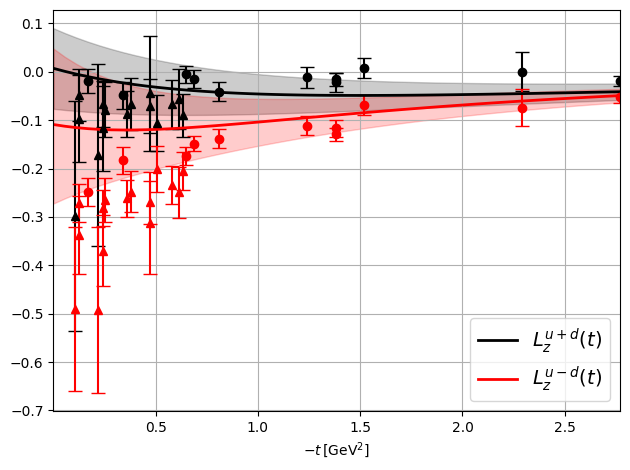

In [ ]:
from stringy_gpds.core import plot_orbital_angular_momentum
plot_orbital_angular_momentum(0,2,evolution_order="nlo")

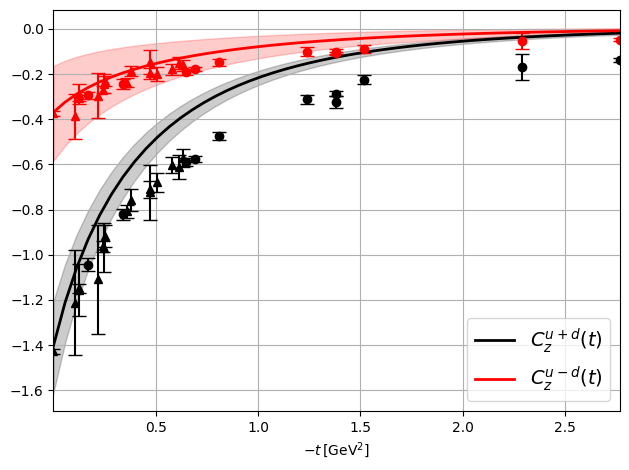

In [ ]:
from stringy_gpds.core import plot_spin_orbit_correlation
plot_spin_orbit_correlation(0,2,evolution_order="nlo")

Plots of conformal moments $\mathbb{G}(n,\eta,t)$ in momentum space

In [4]:
from stringy_gpds.core import plot_moments_on_grid

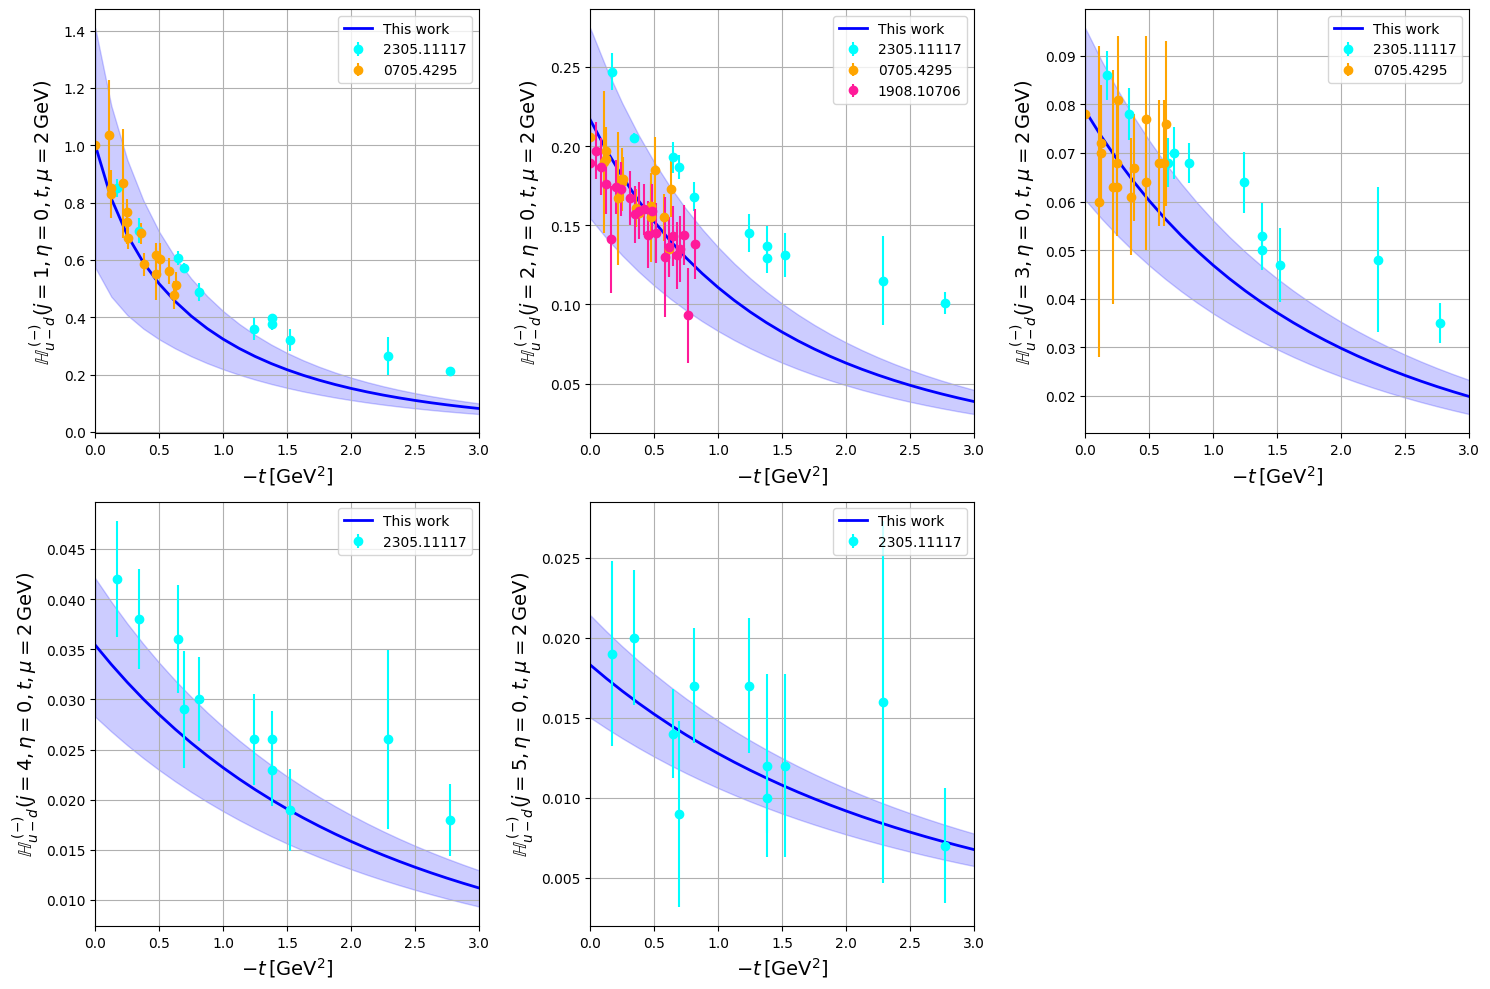

In [7]:
#non_singlet_isovector
y_label = "$\\mathbb{{H}}_{{u-d}}^{{\,\,(-)}}$"
moment_type = "non_singlet_isovector"
moment_label = "A"

plot_moments_on_grid(0,y_label,3,1,"quark",moment_type, moment_label,"nlo",25)

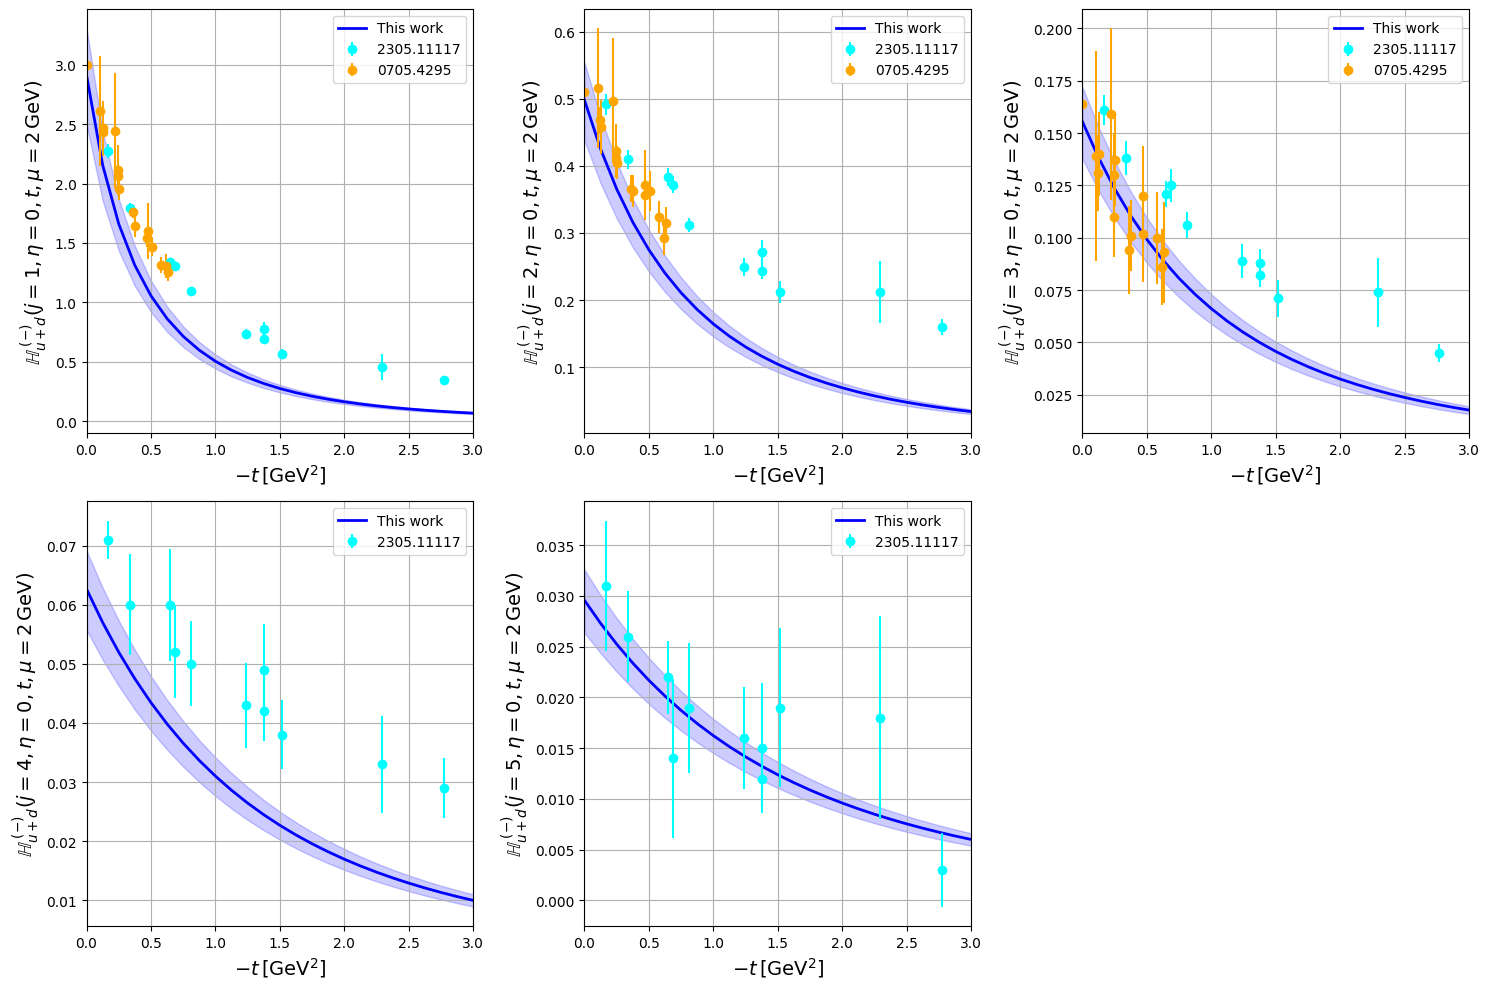

In [8]:
# non_singlet_isoscalar
y_label = "$\\mathbb{{H}}_{{u+d}}^{{\,\,(-)}}$"
moment_type = "non_singlet_isoscalar"
moment_label = "A"

plot_moments_on_grid(0,y_label,3,1,"quark",moment_type, moment_label,"nlo",25)

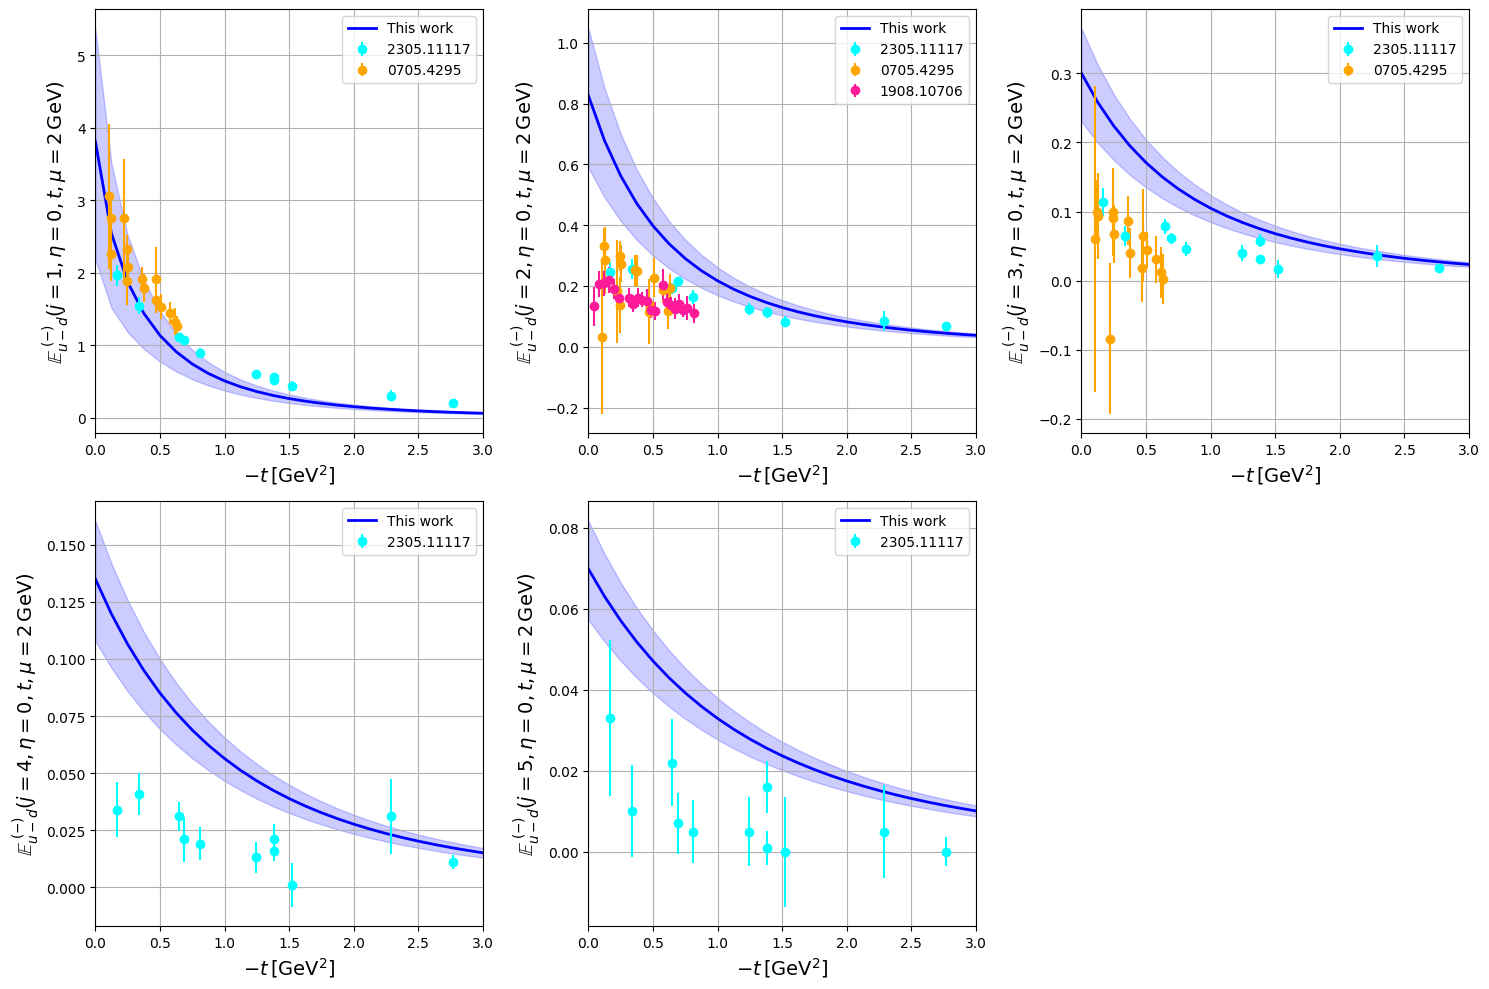

In [9]:
#non_singlet_isovector
y_label = "$\\mathbb{{E}}_{{u-d}}^{{\,\,(-)}}$"
moment_type = "non_singlet_isovector"
moment_label = "B"

plot_moments_on_grid(0,y_label,3,1,"quark",moment_type, moment_label,"nlo",25)

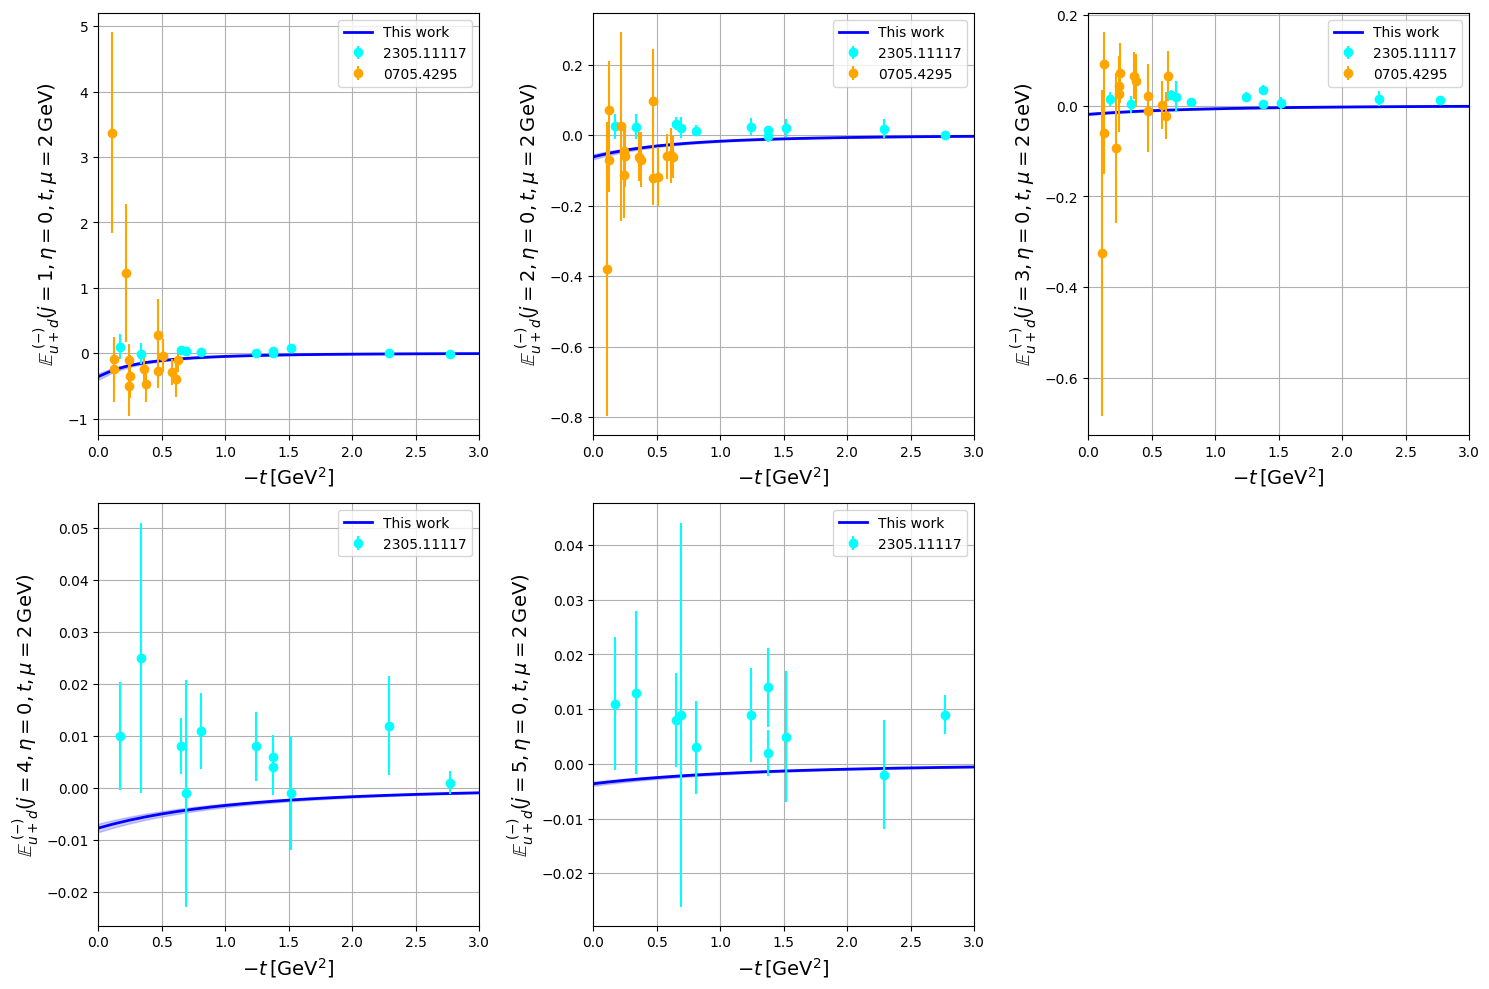

In [10]:
# non_singlet_isoscalar
y_label = "$\\mathbb{{E}}_{{u+d}}^{{\,\,(-)}}$"
moment_type = "non_singlet_isoscalar"
moment_label = "B"

plot_moments_on_grid(0,y_label,3,1,"quark",moment_type, moment_label,"nlo",25)

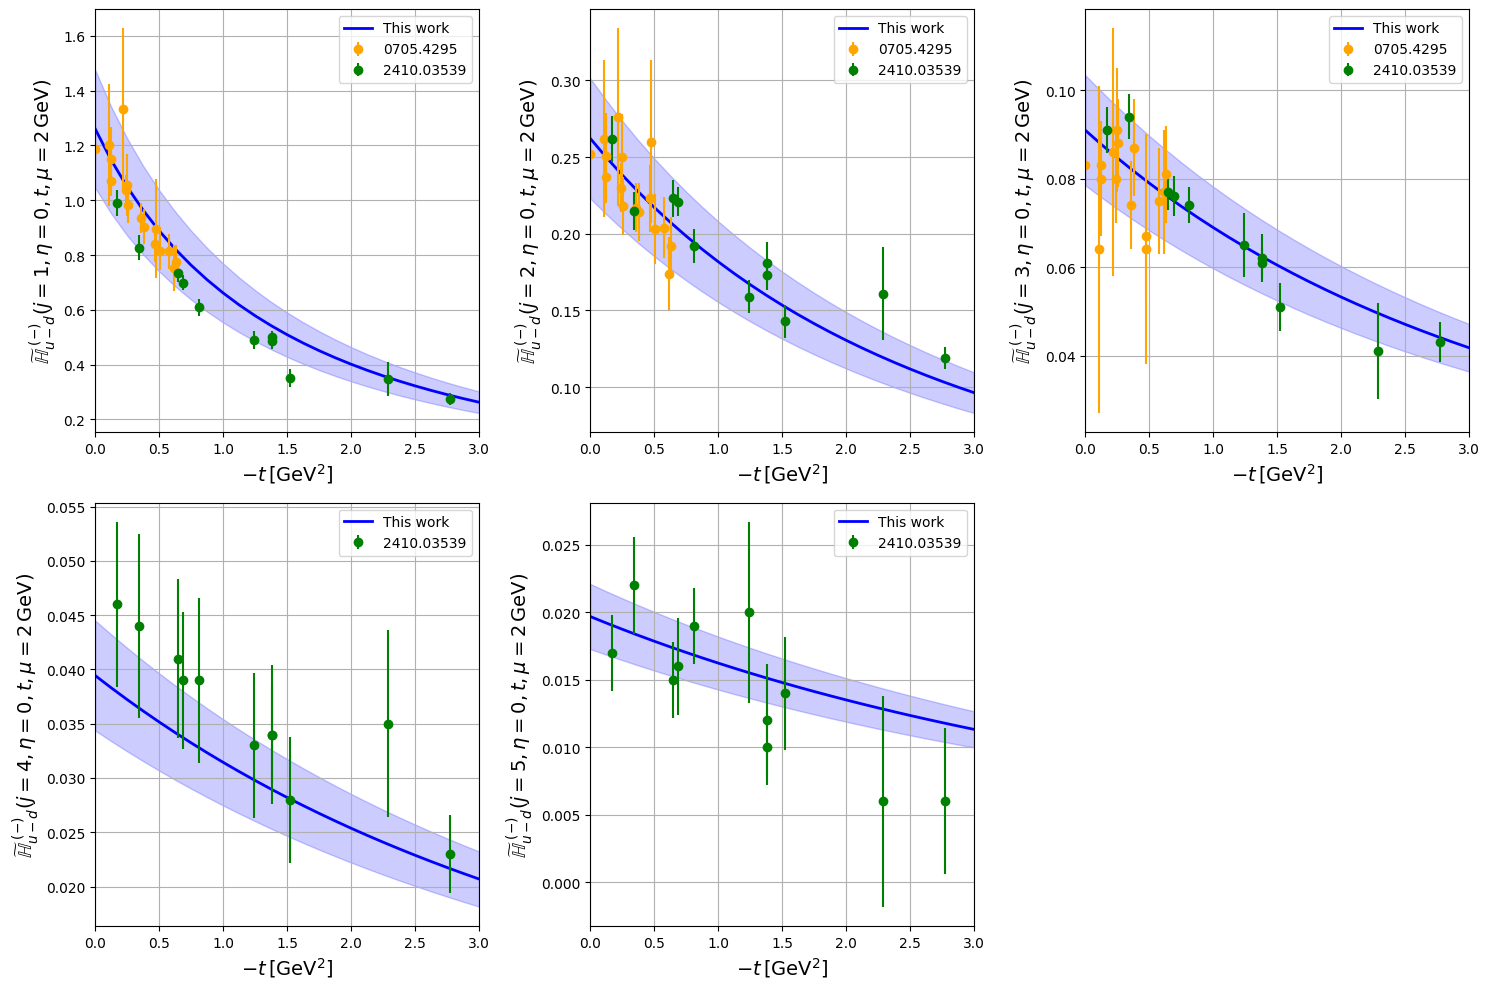

In [11]:
#non_singlet_isovector Axial
y_label = "$\\widetilde{\\mathbb{{H}}}_{{u-d}}^{{\,\,(-)}}$"
moment_type = "non_singlet_isovector"
moment_label = "Atilde"

plot_moments_on_grid(0,y_label,3,1,"quark",moment_type, moment_label,"nlo",25)

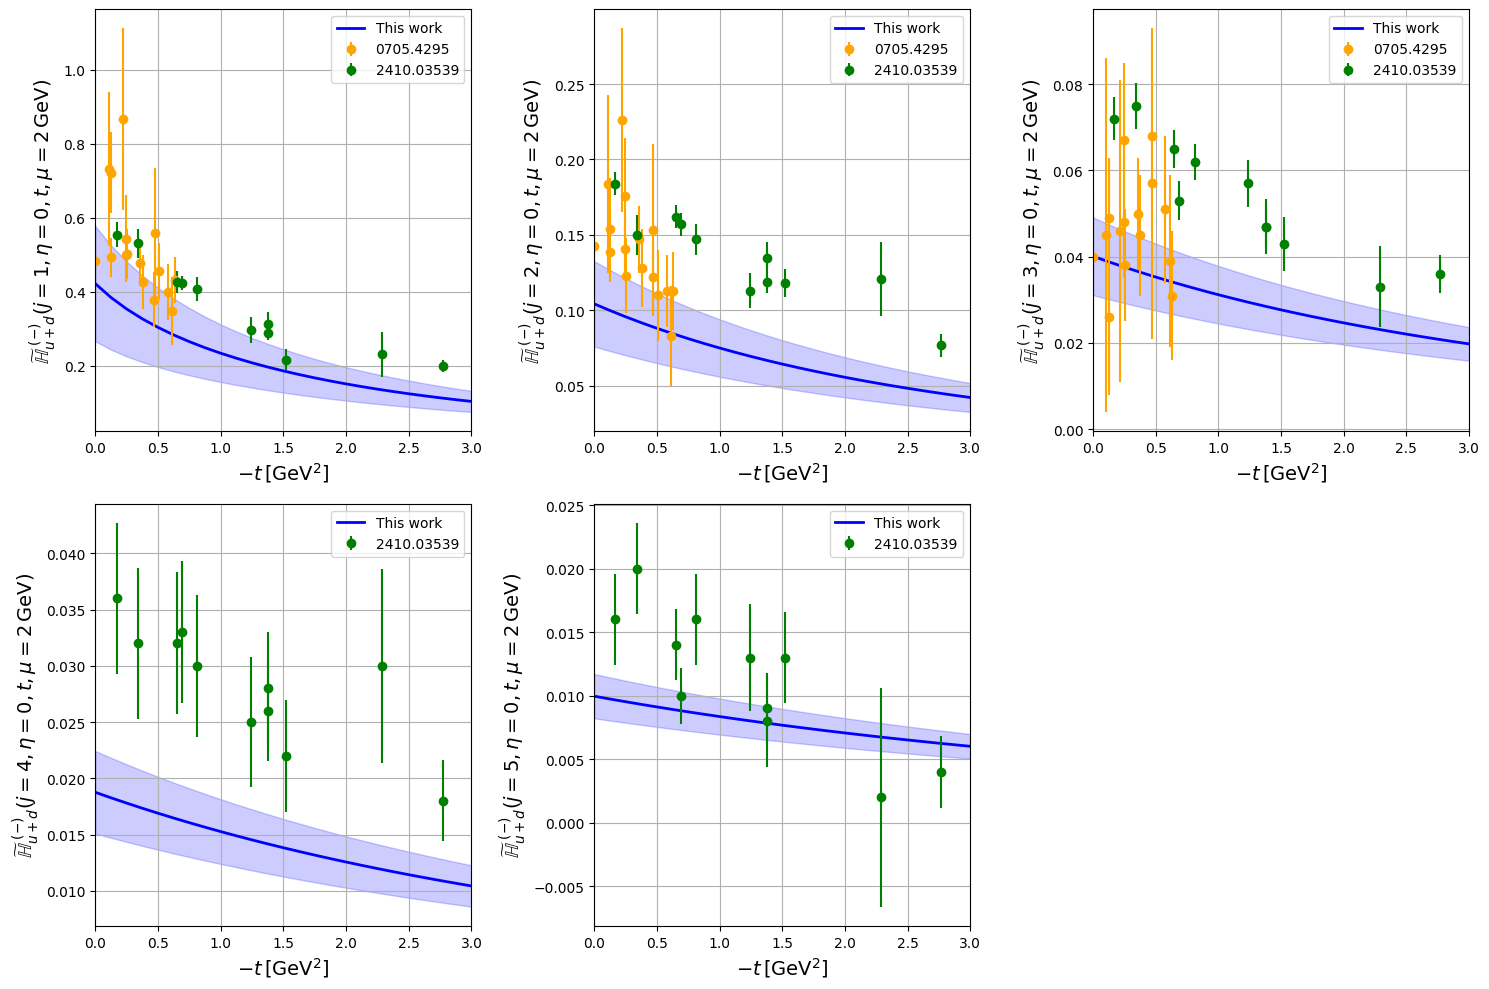

In [12]:
#non_singlet_isoscalar Axial
y_label = "$\\widetilde{\\mathbb{{H}}}_{{u+d}}^{{\,\,(-)}}$"
moment_type = "non_singlet_isoscalar"
moment_label = "Atilde"

plot_moments_on_grid(0,y_label,3,1,"quark",moment_type, moment_label,"nlo",25)

In [2]:
from stringy_gpds.core import evolve_conformal_moment
A0q = 0.51/evolve_conformal_moment(2,0,0,2,moment_type="singlet",particle="quark",evolution_order="nlo")
A0g = 0.501/evolve_conformal_moment(2,0,0,2,moment_type="singlet",particle="gluon",evolution_order="nlo")
print(A0q,A0g)

0.7898982411187685 1.4138908580914216


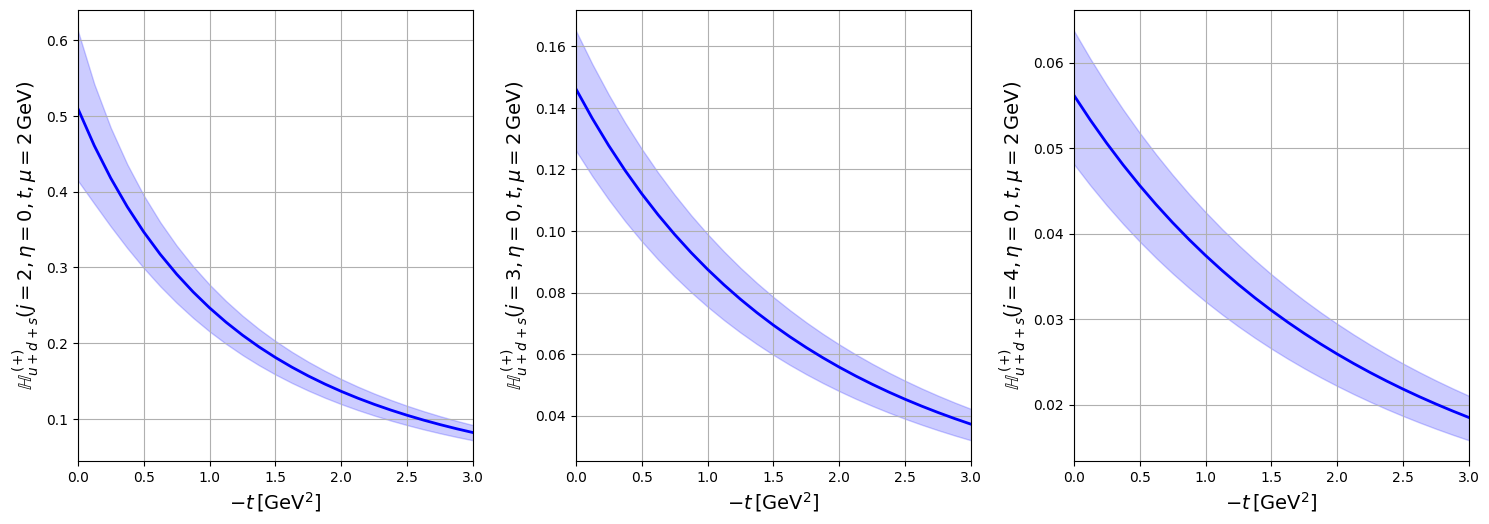

In [6]:
# Sea Quark singlet
y_label = "$\\mathbb{{H}}_{{u+d+s}}^{{\,\,(+)}}$"
moment_type = "singlet"
moment_label = "A"

plot_moments_on_grid(0,y_label,3,A0q,"quark",moment_type, moment_label,"nlo",25)

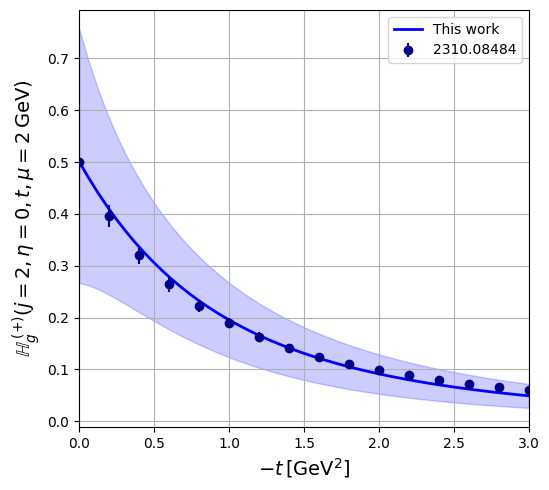

In [7]:
from stringy_gpds.core import plot_moments_on_grid
y_label = "$\\mathbb{{H}}_{{g}}^{{\,\,(+)}}$"
particle = "gluon"
moment_type = "singlet"
moment_label = "A"
plot_moments_on_grid(0,y_label,3,A0g,particle,moment_type,moment_label,evolution_order="nlo",n_t=50)

In [8]:
from stringy_gpds.core import evolve_singlet_D
D0g = -2.572/evolve_singlet_D(2,1,-1e-6,2,particle="gluon",moment_label="A",evolution_order="nlo")
D0q = -1.30/evolve_singlet_D(2,1,-1e-6,2,particle="quark",moment_label="A",evolution_order="nlo")
print(D0q,D0g)

0.7531204556265345 0.7022477553524469


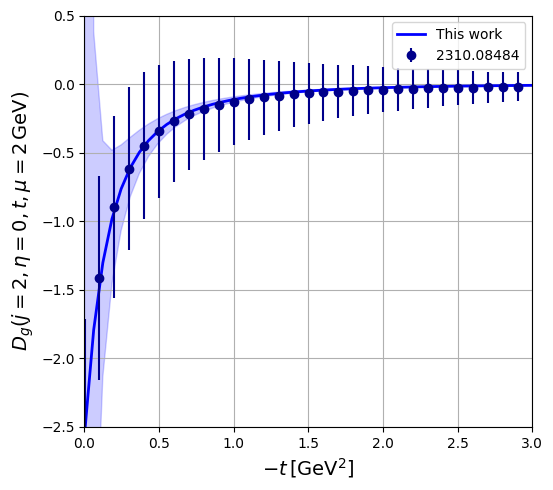

In [9]:
y_label = "$D_{{g}}$"
particle = "gluon"
moment_type = "singlet"
moment_label = "A"
plot_moments_on_grid(1,y_label,3,D0g,particle,moment_type,moment_label,D_term=True,y_0 = -2.5, y_1=.5,set_y_lim=True,evolution_order="nlo")

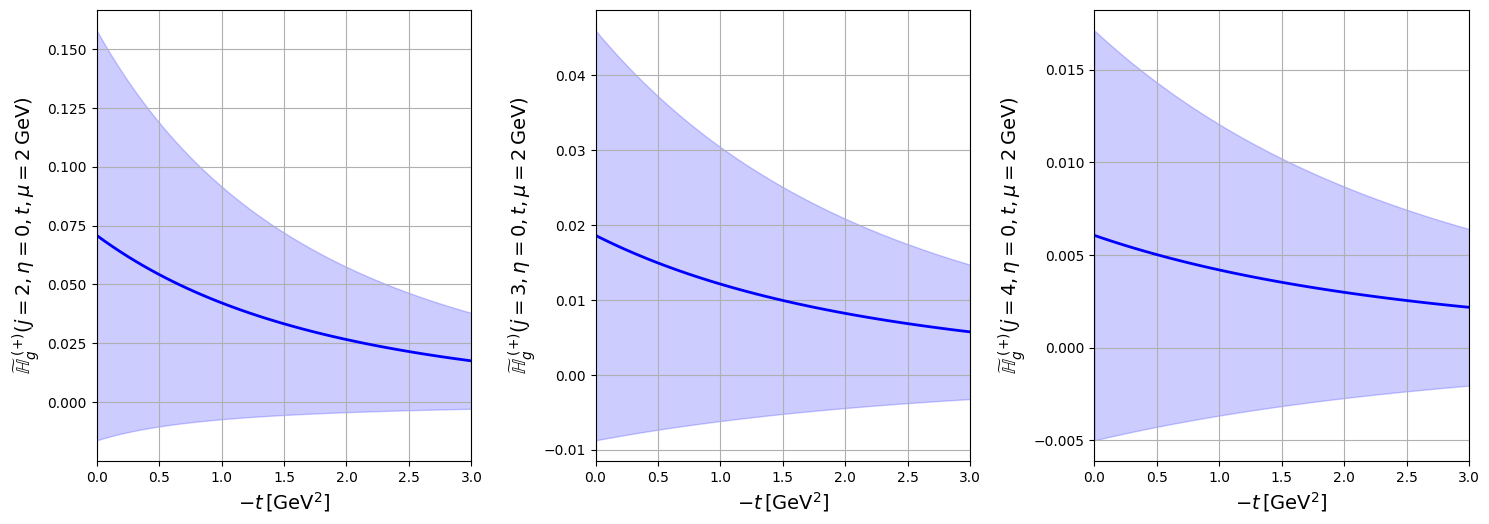

In [10]:
# Gluon singlet
y_label = "$\\widetilde{\\mathbb{{H}}}_{{g}}^{{\,\,(+)}}$"
moment_type = "singlet"
moment_label = "Atilde"

plot_moments_on_grid(0,y_label,3,1,"gluon",moment_type, moment_label,evolution_order="nlo")

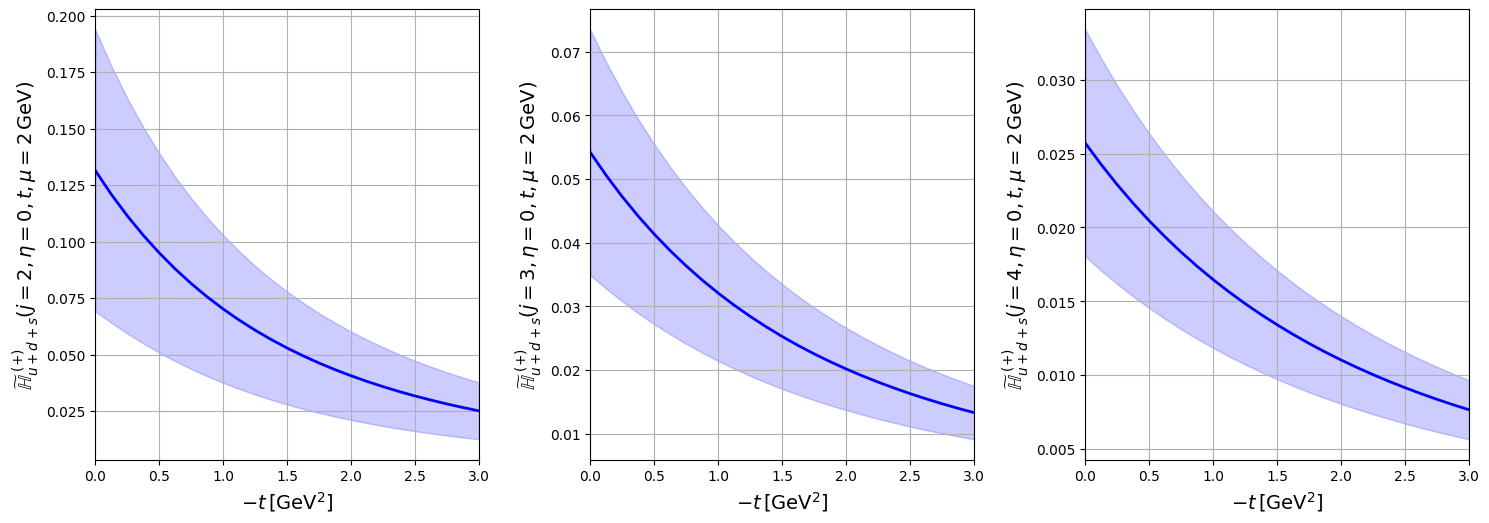

In [11]:
# Sea Quark singlet
y_label = "$\\widetilde{\\mathbb{{H}}}_{{u+d+s}}^{{\,\,(+)}}$"
moment_type = "singlet"
moment_label = "Atilde"

plot_moments_on_grid(0,y_label,3,1,"quark",moment_type, moment_label,"nlo",25)

In [15]:
from stringy_gpds.core import evolve_conformal_moment
print(evolve_conformal_moment(1,0,0,1,particle="quark",moment_type="singlet",evolution_order="nlo",moment_label="Atilde"))
print(evolve_conformal_moment(1,0,0,1,particle="gluon",moment_type="singlet",evolution_order="nlo",moment_label="Atilde"))

print(evolve_conformal_moment(1,0,0,2,particle="quark",moment_type="singlet",evolution_order="nlo",moment_label="Atilde"))
print(evolve_conformal_moment(1,0,0,2,particle="gluon",moment_type="singlet",evolution_order="nlo",moment_label="Atilde"))

0.36910545228849206
0.3120004940580565
0.31175495357954636
0.9703123288905886


In [14]:
import stringy_gpds.core as sgpds
import stringy_gpds.config as cfg

def gamma_qq_nlo(j):
    # Belitsky K.5
    s_0 = sgpds.harmonic_number(0,j+1,interpolation=False)
    s_1 = sgpds.harmonic_number(1,j+1,interpolation=False)
    s_2 = sgpds.harmonic_number(2,j+1,interpolation=False)
    s_2_prime = sgpds.harmonic_number_prime(2,j+1)
    s_tilde = sgpds.harmonic_number_tilde(j+1)
    s_3_prime = sgpds.harmonic_number_prime(3,j+1)
    term1 = (sgpds.C_F**2 - .5 * sgpds.C_F * sgpds.C_A)*(
                4 * (2 * j + 3)/((j + 1 )**2 * (j + 2)**2)*s_0
                - 2 * (3 * j**3 +10 * j**2 + 11*j +3)/((j + 1 )**3 * (j + 2)**2)
                + 4 * (2 * s_1 - 1/((j + 1)*(j + 2))) * (s_2 - s_2_prime)
                + 16 * s_tilde + 6 * s_2 - .75 - 2 * s_3_prime
                + 4 * (-1)**(j+1) * (2 * j**2 + 6 * j + 5)/((j + 1 )**3 * (j + 2)**3)
            )
    term2 = sgpds.C_F * sgpds.C_A *( s_1 * (134/9 + 2 * (2*j +3 )/((j+1)**2*(j+2)**2) )
                        - 4 * s_1 * s_2 + s_2 *(-13/3 +2/((j+1)*(j+2)))
                        -43/24 - 1/9 * (151*j**4 + 867 * j**3 +1792*j**2 + 1590*j + 523)/\
                        ((j+1)**3*(j+2)**3)
                        )
    term3 = sgpds.C_F * sgpds.T_F * cfg.N_F * (-40/90*s_1 +8/3*s_2 +1/3 +4/9 * (11*j**2 +27*j+13)/((j+1)**2*(j+2)**2))
    nlo_term = term1 + term2 + term3
    result = nlo_term
    result += 4 * sgpds.C_F * sgpds.T_F * cfg.N_F * (j+3) * (4 + 5*j + 3 * j**2 + j**3)/((j+1)**3*(j+2)**3)
    return result

def gamma_qg_nlo(j):
    s_1 = sgpds.harmonic_number(1,j+1,interpolation=False)
    s_2 = sgpds.harmonic_number(2,j+1,interpolation=False)
    s_2_prime = sgpds.harmonic_number_prime(2,j+1)
    term1 = 2 * sgpds.C_F * sgpds.T_F * cfg.N_F  * (
        - (j * (16 + 49 * j + 60 * j**2 + 30 * j**3 + 5 * j**4)) / ((j + 1)**3 * (j + 2)**3) +
        (4 * j / ((j + 1)**2 * (j + 2))) * s_1 -
        (2 * j / ((j + 1) * (j + 2))) * (s_1**2 - s_2)
    )

    term2 = 4 * sgpds.C_A * sgpds.T_F * cfg.N_F * (
        (8 + 4 * j - 7 * j**2 - 10 * j**3 - 6 * j**4 - j**5) / ((j + 1)**3 * (j + 2)**3) -
        (4 * s_1 / ((j + 1) * (j + 2)**2)) +
        (j / ((j + 1) * (j + 2))) * (s_1**2 - s_2 + s_2_prime)
    )
    return term1 + term2
def gamma_gq_nlo(j):
    s_1 = sgpds.harmonic_number(1,j+1,interpolation=False)
    s_2 = sgpds.harmonic_number(2,j+1,interpolation=False)
    s_2_prime = sgpds.harmonic_number_prime(2,j+1)
    term1 = 8 * sgpds.C_F * sgpds.T_F * cfg.N_F * (
        ((j + 3) * (5 * j + 7)) / (9 * (j + 1) * (j + 2)**2) -
        ((j + 3) / (3 * (j + 1) * (j + 2))) * s_1
    )
    term2 = sgpds.C_F**2 * (
        ((j + 3) * (3 * j + 4) * (3 + 14 * j + 12 * j**2 + 3 * j**3)) / ((j + 1)**3 * (j + 2)**3) -
        (2 * (j + 3) * (3 * j + 4)) / ((j + 1) * (j + 2)**2) * s_1 +
        (2 * (j + 3) / ((j + 1) * (j + 2))) * (s_1**2 + s_2)
    )
    term3 = 2 * sgpds.C_A * sgpds.C_F * (
        - (750 + 2380 * j + 3189 * j**2 + 2098 * j**3 + 651 * j**4 + 76 * j**5) / (9 * (j + 1)**3 * (j + 2)**3) +
        ((45 + 44 * j + 11 * j**2) / (3 * (j + 1)**2 * (j + 2))) * s_1 +
        ((j + 3) / ((j + 1) * (j + 2))) * (-s_1**2 - s_2 + s_2_prime)
    )
    return term1 + term2 + term3
def gamma_gg_nlo(j):
    s_1 = sgpds.harmonic_number(1,j+1,interpolation=False)
    s_2_prime = sgpds.harmonic_number_prime(2,j+1)
    s_tilde = sgpds.harmonic_number_tilde(j+1)
    s_3_prime = sgpds.harmonic_number_prime(3,j+1)
    term1 = 2 * sgpds.C_F * sgpds.T_F * cfg.N_F * (
        (8 + 30 * j + 70 * j**2 + 71 * j**3 + 35 * j**4 + 9 * j**5 + j**6) /
        ((j + 1)**3 * (j + 2)**3)
    )
    term2 = 8 * sgpds.C_A * sgpds.T_F * cfg.N_F * (
        (35 + 75 * j + 52 * j**2 + 18 * j**3 + 3 * j**4) / (9 * (j + 1)**2 * (j + 2)**2) -
        (5 / 9) * s_1
    )
    term3 = sgpds.C_A**2 * (
        - (1768 + 5250 * j + 7075 * j**2 + 4974 * j**3 + 1909 * j**4 + 432 * j**5 + 48 * j**6) /
        (9 * (j + 1)**3 * (j + 2)**3) +
        (2 / 9) * (484 + 948 * j + 871 * j**2 + 402 * j**3 + 67 * j**4) / ((j + 1)**2 * (j + 2)**2) * s_1 +
        (8 / ((j + 1) * (j + 2))) * s_2_prime -
        4 * s_1 * s_2_prime - s_3_prime +
        8 * s_tilde
    )
    return term1 + term2 + term3
import mpmath as mp
def gamma_gg_lo(j):
    term1 = sgpds.C_A * (8 * sgpds.harmonic_number(1,j) - 8/(j+1) + 16/(j+2) - 22/3)
    term2 = 8/3 * sgpds.T_F * cfg.N_F
    result = term1 + term2
    return result/2

def test(j):
    s_1 = sgpds.harmonic_number(1,j+1)
    s_3_p = sgpds.harmonic_number(3,j+2)
    s_3_m = sgpds.harmonic_number(3,j)
    s_1_p = sgpds.harmonic_number(1,j+2)
    s_1_m = sgpds.harmonic_number(1,j)
    s_2_p = sgpds.harmonic_number(2,j+2)
    s_2_m = sgpds.harmonic_number(2,j)
    return 16 * ( (s_2_m - s_2_p) - (s_3_m - s_3_p) - 2 * (s_1_m + s_1_p - 2 * s_1))

def gamma_qg_vec(j):
    s_1 = sgpds.harmonic_number(1,j+1)
    s_2 = sgpds.harmonic_number(2,j+1)
    s_2_prime = sgpds.harmonic_number_prime(2,j+1)
    term1 = -2 * sgpds.C_A * sgpds.T_F * cfg.N_F * (
        (-2 * s_1**2 + 2 * s_2 - 2 * s_2_prime) * ((j**2 + 3 * j + 4) / ((j + 1) * (j + 2) * (j + 3))) +
        (960 + 2835 * j + 4057 * j**2 + 3983 * j**3 + 3046 * j**4 + 1777 * j**5 +
        731 * j**6 + 195 * j**7 + 30 * j**8 + 2 * j**9) / (j * (j + 1)**3 * (j + 2)**3 * (j + 3)**3) +
        (-1)**(j + 1) * (141 + 165 * j + 92 * j**2 + 27 * j**3 + 3 * j**4) /
        ((j + 1) * (j + 2)**3 * (j + 3)**3) +
        8 * (2 * j + 5) / ((j + 2)**2 * (j + 3)**2) * s_1
    )
    term2 = -2 * sgpds.C_F * sgpds.T_F * cfg.N_F * (
        (2 * s_1**2 - 2 * s_2 + 5) * ((j**2 + 3 * j + 4) / ((j + 1) * (j + 2) * (j + 3))) -
        4 * s_1 / ((j + 1)**2) +
        (11 * j**4 + 70 * j**3 + 159 * j**2 + 160 * j + 64) /
        ((j + 1)**3 * (j + 2)**3 * (j + 3))
    )
    result = term1 + term2
    result*=j/6
    return result

# print(gamma_gg_lo(0))
# print(sgpds.gamma_gg_lo(0,interpolation=False,evolve_type="axial"))
# completely different...
# print(gamma_qq_nlo(0))
# print(sgpds.gamma_qq_nlo(1,evolve_type="vector"))
# Agrees up to factor 4
# print(gamma_qg_nlo(0))
# print(sgpds.gamma_qg_nlo(0,evolve_type="axial",interpolation=False))
# # Agrees up to factor 4
# print(gamma_gq_nlo(0))
# print(sgpds.gamma_gq_nlo(0,evolve_type="axial",interpolation=False))

# # Agrees up to factor 4
# print(gamma_gg_nlo(0))
# print(sgpds.gamma_gg_nlo(0,evolve_type="axial",interpolation=False))
# from stringy_gpds.core import harmonic_number, nested_harmonic_number, d_weight
# def test(j):
#     s_1 = harmonic_number(1,j+1)
#     s_2 = harmonic_number(2,j+1)
#     s_3 = harmonic_number(3,j+1)
#     s_m2 = harmonic_number(-2,j+1)
#     s_m3 = harmonic_number(-3,j+1)
#     s_1_m2= nested_harmonic_number([1,-2],j+1)
#     s_1_2 = nested_harmonic_number([1,2],j+1)
#     s_2_1 = nested_harmonic_number([2,1],j+1)
#     eta = 1/((j+1)*(j+2))
#     d02 = d_weight(2,0,j + 1)
#     d03 = d_weight(3,0,j + 1)
#     term1 = 4*sgpds.C_F**2 * (-4 * (s_m3 - 2* s_1_m2 - s_1_2 - s_2_1) - 3 * s_2 + 3/8 - 4 * eta * s_m2
#                            -2 * eta * s_2 + 2 * (2 * eta + eta**2 - 2 * d02) * s_1 - eta - 11 * eta**2 - 5 * eta**3 + d02 + 2 * d03)
#     term2 = 4 * sgpds.C_A * sgpds.C_F * ( 2 * (s_m3 - s_3) - 4 * s_1_m2 + 11/3 * s_2 - 67/9 * s_1 + 17/24
#                                          +2 * eta * s_m2 + 217/18 * eta + 35/6 * eta**2 + 2 * eta**3 - 11/3 * d02)
#     term3 = 4/9 * sgpds.C_F*cfg.N_F * (-6 * s_2 + 10 * s_1 -3/4 - 17 * eta - 3 *eta**2 + 6 * d02)
#     return term1 + term2 + term3

    
# # test(0)
# (7 * sgpds.C_A * sgpds.C_F - 14 * sgpds.C_F**2)
# gamma_qq_nlo(0)
print(gamma_qg_vec(2))
# test(0)

(-0.30870679012791025+0j)


In [1]:
import stringy_gpds.core as sgpds
q = sgpds.evolve_conformal_moment(2,0,0,2,moment_type="singlet",interpolation=False,evolution_order="nlo")
g = sgpds.evolve_conformal_moment(2,0,0,2,moment_type="singlet",particle="gluon",interpolation=False,evolution_order="nlo")
print(q+g)
q = sgpds.evolve_conformal_moment(1,0,0,2,moment_type="non_singlet_isovector",interpolation=False,evolution_order="nlo")
print(q)
q = sgpds.evolve_conformal_moment(1,0,0,1,moment_type="non_singlet_isovector",interpolation=False,evolution_order="nlo",moment_label="Atilde")
print(q)
q = sgpds.evolve_conformal_moment(1,0,0,2,moment_type="non_singlet_isovector",interpolation=False,evolution_order="nlo",moment_label="Atilde")
print(q)

0.9999943854455333
0.9999511870944298
1.2607256234553916
1.2607256998648046


In [8]:
import stringy_gpds.core as sgpds
j=10
print(sgpds.gamma_pm(j,evolve_type="vector",solution="+",interpolation=False),sgpds.gamma_pm(j,evolve_type="vector",solution="-",interpolation=False))
print(sgpds.gamma_pm(j,evolve_type="axial",solution="+",interpolation=False),sgpds.gamma_pm(j,evolve_type="axial",solution="-",interpolation=False))

-12.0773408154751 -27.0609838228496
-12.0778408872135 -27.064679555307


In [1]:
import stringy_gpds.core as sgpds
q = sgpds.evolve_conformal_moment(1,0,0,1,moment_type="singlet",interpolation=False,evolution_order="nlo",moment_label="Atilde")
g = sgpds.evolve_conformal_moment(1,0,0,1,moment_type="singlet",particle="gluon",interpolation=False,evolution_order="nlo",moment_label="Atilde")
print(q,g)
q = sgpds.evolve_conformal_moment(1,0,0,2,moment_type="singlet",interpolation=False,evolution_order="nlo",moment_label="Atilde")
g = sgpds.evolve_conformal_moment(1,0,0,2,moment_type="singlet",particle="gluon",interpolation=False,evolution_order="nlo",moment_label="Atilde")
print(q,g)

0.36910545228849206 0.31200049405805663
0.34414736778714106 0.28946902549982045


In [1]:
import stringy_gpds.core as sgpds
q = sgpds.evolve_conformal_moment(2,0,0,2,moment_type="non_singlet_isovector",interpolation=False,evolution_order="nlo")
print(q)
q = sgpds.evolve_conformal_moment(2,0,0,1,moment_type="non_singlet_isovector",interpolation=False,evolution_order="nlo",moment_label="Atilde")
print(q)
q = sgpds.evolve_conformal_moment(2,0,0,2,moment_type="non_singlet_isovector",interpolation=False,evolution_order="nlo",moment_label="Atilde")
print(q)

0.19827201226313232
0.24445426533401068
0.23691350628747931


In [ ]:
# Needs to be 16: 24 * sgpds.C_F*sgpds.T_F = sgpds.gamma_qq(0,evolve_type="axial",evolution_order="nlo",moment_type="singlet"))
# qg is correct (0)
# gamma_gq_lo is off by a factor of 2. Maybe T_F in C_F term? Should be - 6 C_F
# gamma_gq_nlo is off by -32/9 should be 18 * sgpds.C_F**2 - 142/3 * sgpds.C_A * sgpds.C_F + 8/3 * sgpds.C_F * sgpds.T_F
# gamma_gg_lo of by a factor of -2 check for T_F
# gamma_gg_nlo off by -1
import stringy_gpds.core as sgpds
import stringy_gpds.config as cfg
# def ga_gq_mertig(m):s

# # Correct
# print(sgpds.gamma_qq(0,evolve_type="axial",evolution_order="lo",moment_type="singlet",interpolation=False))
# print(0)
# # Correct but maybe factor of 3 (is from N_F!)
# print(sgpds.gamma_qq(0,evolve_type="axial",evolution_order="nlo",interpolation=False))
# print(0)

# # # Correct
# print(sgpds.gamma_qg(0,evolve_type="axial",evolution_order="lo",interpolation=False))
# print(0)
# # # # Correct
# print(sgpds.gamma_qg(0,evolve_type="axial",evolution_order="nlo",interpolation=False))
# print(0)


# # # Factor 2 from Mellin moment convention
# print(2 * sgpds.gamma_gq(0,evolve_type="axial",evolution_order="lo",interpolation=False))
# print(-6 * sgpds.C_F)
# # print(ga_gq_mertig(0))

# # Factor 2 from Mellin moment convention and a second factor 2 from god knows where
# print(2 * sgpds.gamma_gq(0,evolve_type="axial",evolution_order="nlo",interpolation=False).real)
# print(e)

# # Factor 2 from Mellin moment convention
# print(2 * sgpds.gamma_gg(0,evolve_type="axial",evolution_order="lo",interpolation=False))
# # # Different BETA convention so no - and anomalous dimension * 2 from Mellin-Moment definition
# print(2*sgpds.BETA_0)

# # Factor 2 from Mellin moment convention and a second factor 2 from god knows where
# print(2 * sgpds.gamma_gg(0,evolve_type="axial",evolution_order="nlo",interpolation=False))
# print(2*sgpds.BETA_1)

17.9999999999485
(127.99980998162297+0j)


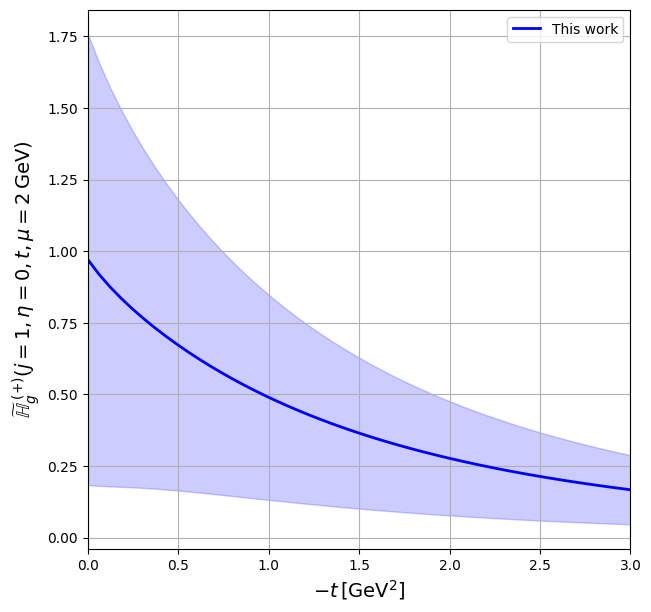

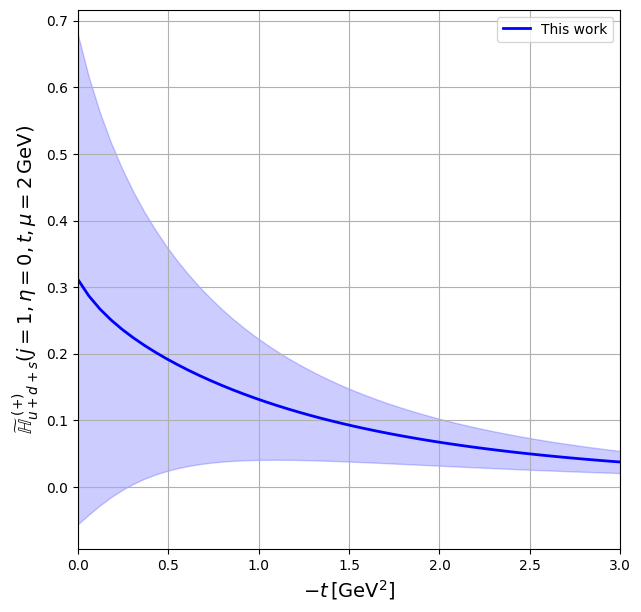

In [12]:
from stringy_gpds.core import plot_moment
y_label = "$\\widetilde{\\mathbb{{H}}}_{{g}}^{{\,\,(+)}}$"
plot_moment(1,0,y_label,2,3,particle="gluon",moment_type="singlet", moment_label="Atilde",evolution_order="nlo")
y_label = "$\\widetilde{\\mathbb{{H}}}_{{u+d+s}}^{{\,\,(+)}}$"
plot_moment(1,0,y_label,2,3,particle="quark",moment_type="singlet", moment_label="Atilde",evolution_order="nlo")

Plots of GPDs through Mellin-Barnes Integral